In [499]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
from scipy.stats import boxcox
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import numpy as np
import tensorflow as tf
from scikeras.wrappers import KerasClassifier
from deap import creator, base, tools, algorithms
import functools
import random
from sklearn import svm
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules


The objective of our analysis is to determine whether a patient will be readmitted to the hospital within a 30-day timeframe. The variable of interest encompasses three categories, namely, readmission within less than 30 days, readmission after more than 30 days, and no readmission. To facilitate binary classification, we have combined the categories of no readmission and readmission after more than 30 days into a single category, labeled as "0." The category of readmission within less than 30 days has been labeled as "1."

# Exploratory data Analysis and preprocessing



## Data visualization and manipulation

### Dealing with Missing Values


In [500]:
raw_data = pd.read_csv("./data.csv",na_values=['?','Unknown/Invalid'],low_memory=False)

def missing_data_info(df):
    # some stats about the missing values in the data 
    null_counts = df.isnull().sum()
    null_cols = null_counts[null_counts > 0].index.tolist()

    print("*************************Missing Data info***************************************")
    print("Length of All data : ",len(df ))
    print("Length of data with non nulls : ",len(df.dropna()))
    print("Number of columns with at least one null value:",len(null_cols))
    if len(null_cols) > 0:
        print("Column names and their number of missing values:")
        adf = df[null_cols]
        adf_null_counts = adf.isnull().sum()
        print(adf_null_counts)
    print("****************************************************************")
    
missing_data_info(raw_data) 


*************************Missing Data info***************************************
Length of All data :  101766
Length of data with non nulls :  1043
Number of columns with at least one null value: 8
Column names and their number of missing values:
race                  2273
gender                   3
weight               98569
payer_code           40256
medical_specialty    49949
diag_1                  21
diag_2                 358
diag_3                1423
dtype: int64
****************************************************************


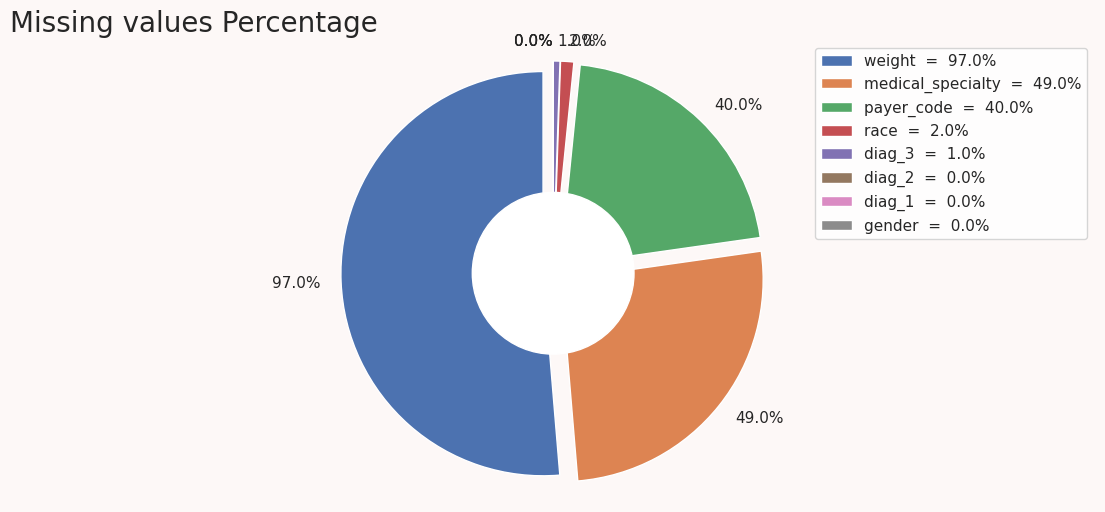

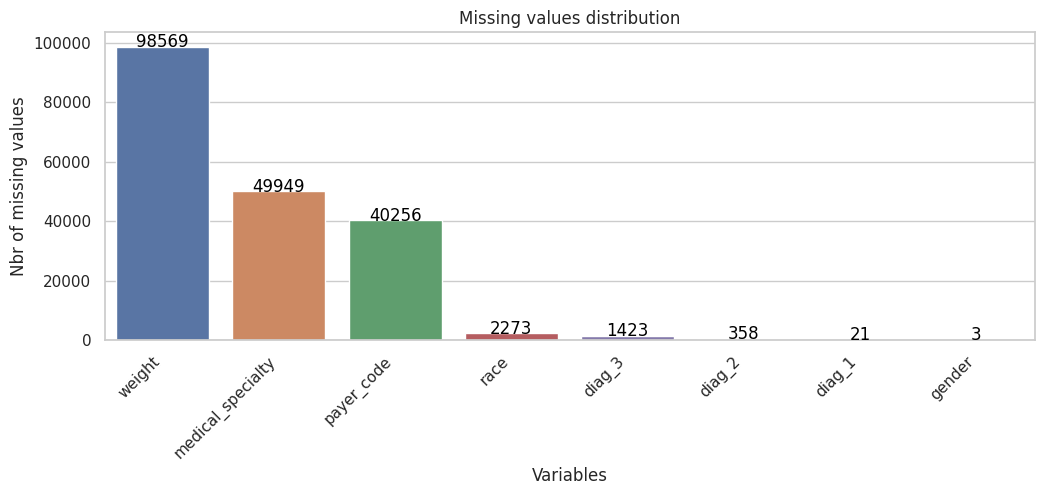

,Variables,total_missing_values,missing_values_rate(%),Nbr_of_unique_values
0,weight,98569,97.0,10
1,medical_specialty,49949,49.0,73
2,payer_code,40256,40.0,18
3,race,2273,2.0,6
4,diag_3,1423,1.0,790
5,diag_2,358,0.0,749
6,diag_1,21,0.0,717
7,gender,3,0.0,3


In [501]:

def bar_chart_plotter(df,x,y,title):
    # Set the style and palette
    sns.set(style="whitegrid")
    colors = sns.color_palette("deep")
    # Create the bar chart
    fig, ax = plt.subplots(figsize=(12, 4))
    sns.barplot(x=df[x], y=df[y], data=df, palette=colors)
    # Set the title and labels
    ax.set_title(title)
    ax.set_xlabel("Variables")
    ax.set_ylabel("Nbr of missing values")
    # Customize the x-axis labels
    plt.xticks(rotation=45, ha="right")
    # Add the values as labels above each bar
    for index, row in df.iterrows():
        ax.text(index, row[y] + 5, str(row[y]), color='black', ha="center")
    # Show the chart
    plt.show()

def pie_chart_plotter(df,x,y, title, labels = None,legend = None):  
    
    fig, ax = plt.subplots(figsize=(14, 6))
    
    num_colors = len(df[y])
    color_palette = sns.color_palette("deep", num_colors)
    colors = color_palette.as_hex()
    
    explode = [0.05]*len(df[y])
   
    ax.pie(df[y], colors=colors ,labels = labels,startangle=90, explode=explode, 
                                  labeldistance=1.1, radius=1)
   
    ax.set_title(title, fontsize=20, loc= 'left')
    
    ax.legend(legend, loc="best")
    # set text properties of labels
    #plt.setp(labels, fontsize=12, fontweight='bold', color='black', bbox=dict(facecolor='white', edgecolor='black'))
   
    # create a circle at the center of the pie
    centre_circle = plt.Circle((0,0),0.40,fc='white')
    fig.gca().add_artist(centre_circle)
    # set equal aspect ratio
    ax.axis('equal')
    # show the plot
    plt.show()



def visualize_missing_data(df):
    data_length = len(df)
    null_counts = df.isnull().sum()
    null_cols =null_counts[null_counts > 0]

    null_stats_df = pd.DataFrame(null_cols, columns=["total_missing_values"])
    null_stats_df[' missing_values_rate(%)'] = ((null_stats_df['total_missing_values'] / data_length ) * 100).round()

    nbr_uniquevals = [len(df[col].unique()) for col in null_cols.index.tolist()]
    uniquevals = [df[col].unique() for col in null_cols.index.tolist()]
    null_stats_df['Nbr_of_unique_values'] = nbr_uniquevals
   
    #pie chart

    null_stats_df = null_stats_df.sort_values(by='total_missing_values', ascending = False)

    null_stats_df.index.name = 'Variables'
    percents = null_stats_df[null_stats_df.columns[1]].astype(str) + '%'
    legend = null_stats_df.index + '  =  '+ percents 

    pie_chart_plotter(null_stats_df,null_stats_df.index,null_stats_df.columns[1],'Missing values Percentage',percents,legend)
   
    #bar chart 
    null_stats_df.reset_index(inplace=True)
    bar_chart_plotter(null_stats_df,null_stats_df.columns[0],null_stats_df.columns[1],'Missing values distribution')
    
    return null_stats_df

visualize_missing_data(raw_data)

- Variables race,gender,diag_1,diag_2,diag_3 have fairly low missing values compaired to others,so we decided to impute the missing values with the most common value.
- Variables gender, payer_code and medical_specialty have respectively 97%,40%,49% missing values so there is no usefulness in filling them, we decided to drop them.
 

In [502]:
# Impute columns with fairly low number of missing values with most common value 
columns_to_impute = ['race', 'gender','diag_1','diag_2','diag_3']
for col in columns_to_impute : 
    most_comon_value = raw_data[col].mode()[0]
    raw_data[col] = raw_data[col].fillna(most_comon_value)

# drop gender, payer_code and medical_specialty
raw_data = raw_data.drop(['weight','payer_code','medical_specialty'], axis = 1) 


### Target Variable distribution

In [503]:
raw_data.readmitted = [1 if val =='<30' else 0 for val in raw_data.readmitted]

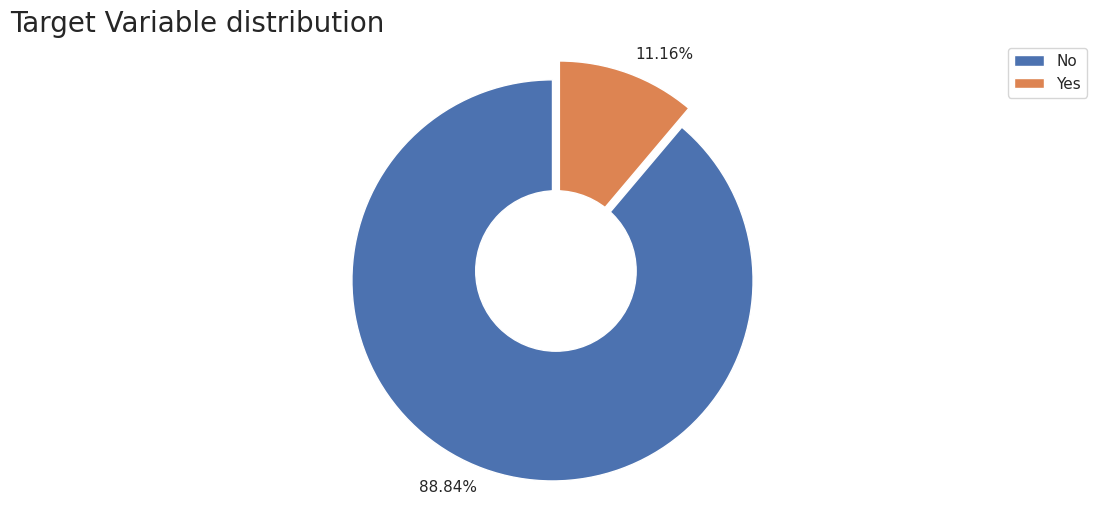

In [504]:
values = raw_data.readmitted.value_counts().tolist()
legend = ['No','Yes']
labels = [ str(round((value / len(raw_data) * 100),2))+'%' for value in values] 
df = pd.DataFrame({'Values' :values, 'labels' :labels })
pie_chart_plotter(df ,'labels', 'Values','Target Variable distribution',labels,legend)


### Feature preparation

#### Utility functions

In [505]:
def plot_feature_distribution(df,feature):
    sns.set(style='whitegrid', rc={'axes.facecolor': '#ffffff','figure.facecolor': '#fdf8f7','axes.grid': False})
    
    plt.figure(figsize=(10,6))
    feature_counts = df[feature].value_counts()
   
    ax = sns.countplot(x=feature, data=raw_data, palette='pastel', order = feature_counts.index )
    plt.xlabel(feature, fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.title('Distribution of '+ feature, fontsize=16)
    
    sns.despine(left=True)
    plt.tick_params(labelsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    
    # add count values for each bar
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.0f'),
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha = 'center', va = 'center', xytext = (0, 10),
                    textcoords = 'offset points', fontsize=12)
    plt.show()


def plot_prob_density(df,col):
    fig = plt.figure(figsize=(10,5))

    #readmitted = 0
    ax = sns.kdeplot(df.loc[(df.readmitted == 0), col],
                    color = "r", shade = True,label = "Not Readmitted")
    #readmitted = 1
    ax = sns.kdeplot(df.loc[(df.readmitted == 1), col],
                    color = "g", shade = True, label = "Readmitted")
    
    ax.legend(loc="upper right")

    ax.set_xlabel(col)
    ax.set_ylabel("Frequency")
    ax.set_title(col+" -  Readmission")
    plt.show()

#### Race

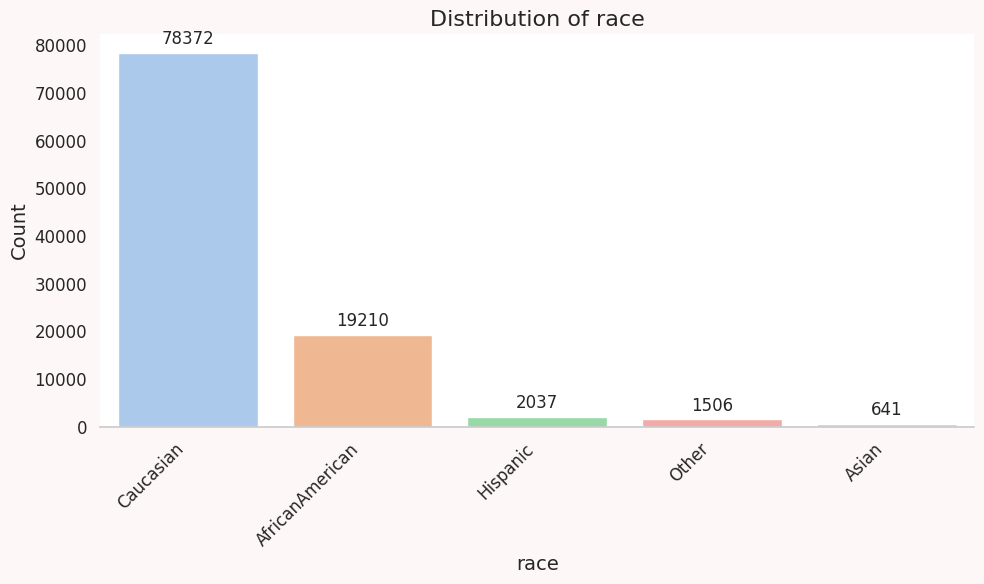

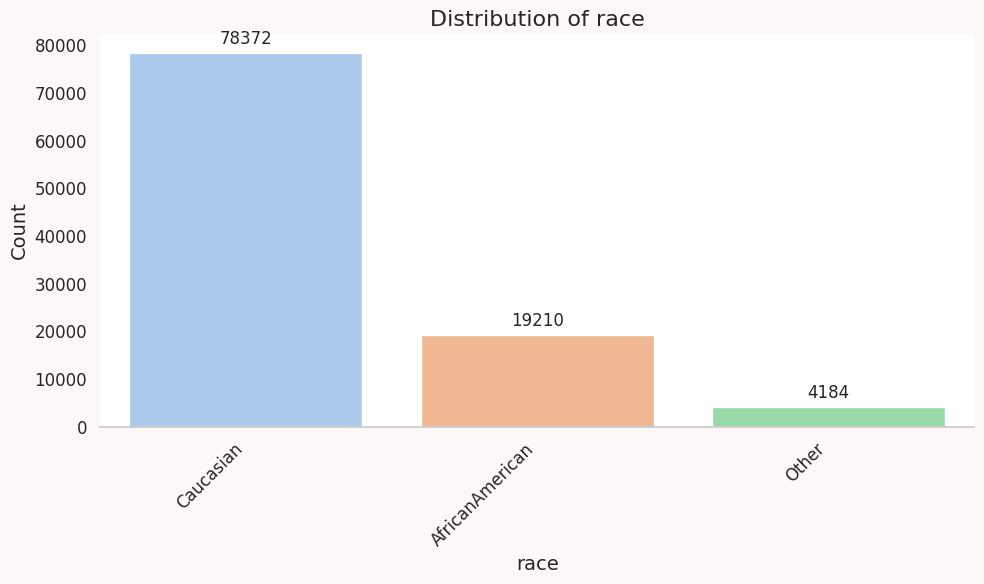

In [506]:
plot_feature_distribution(raw_data,'race')
mapping = {"Asian":"Other","Hispanic":"Other"}
raw_data.race = raw_data.race.replace(mapping)
plot_feature_distribution(raw_data,'race')

#### Age

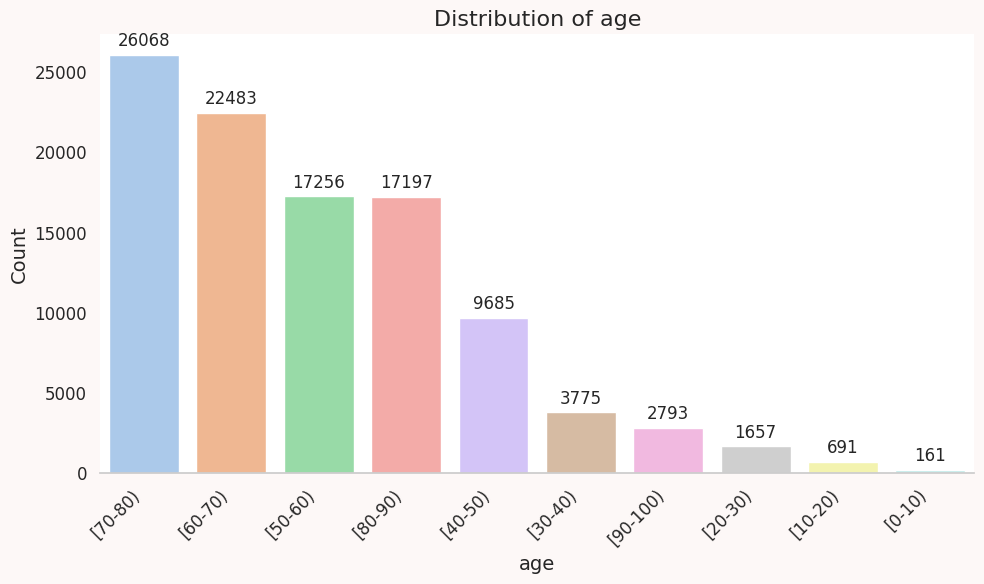

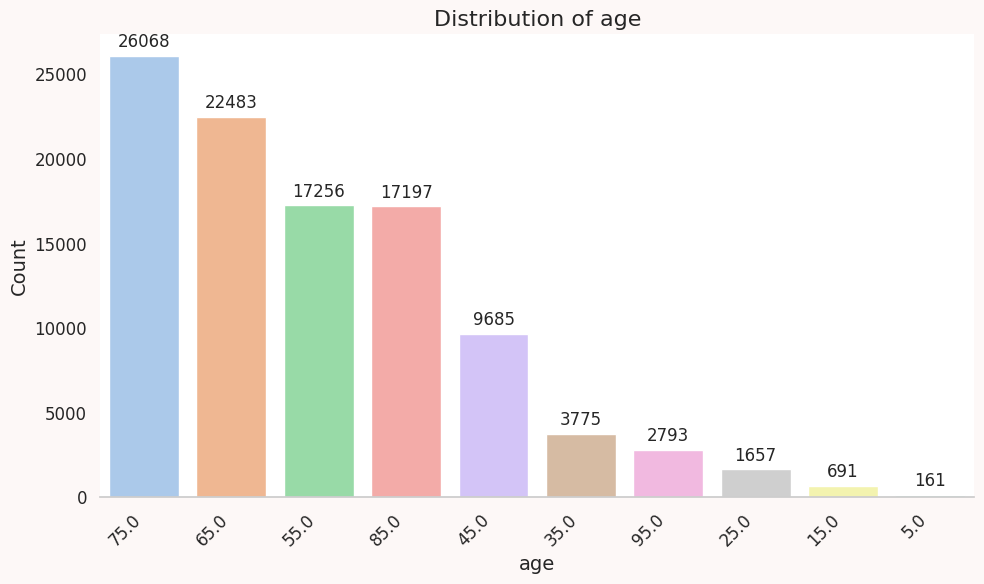

mean age :  65.96702238468644


In [507]:

plot_feature_distribution(raw_data,'age')
raw_data['age'].head(5)
raw_data['age'] = raw_data['age'].apply(lambda x : ( int(x.split('-')[0].strip('[')) +  int(x.split('-')[1].strip(')')) ) / 2 ) 
raw_data['age'].head(5)
plot_feature_distribution(raw_data,'age')

print('mean age : ', raw_data['age'].mean())

#### Gender

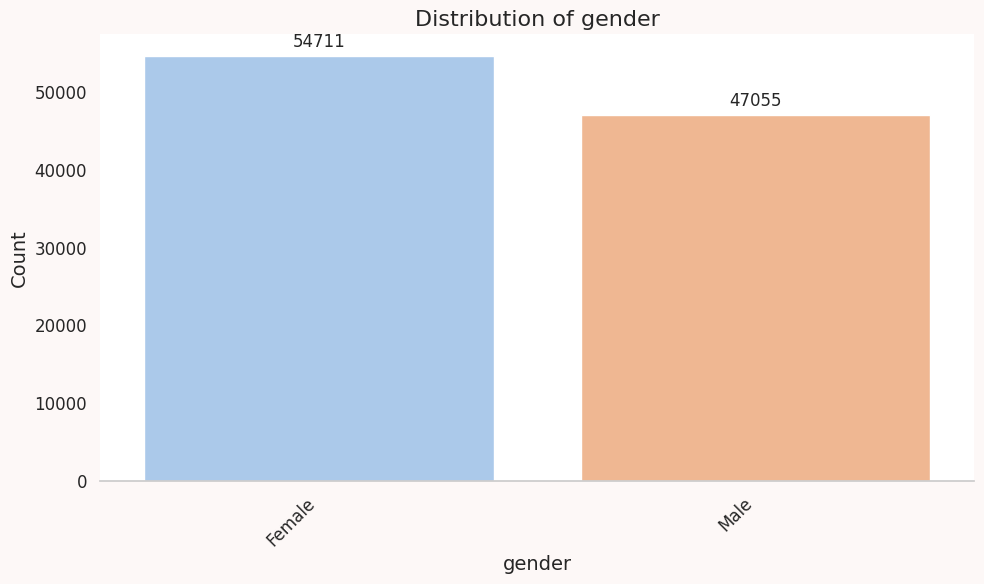

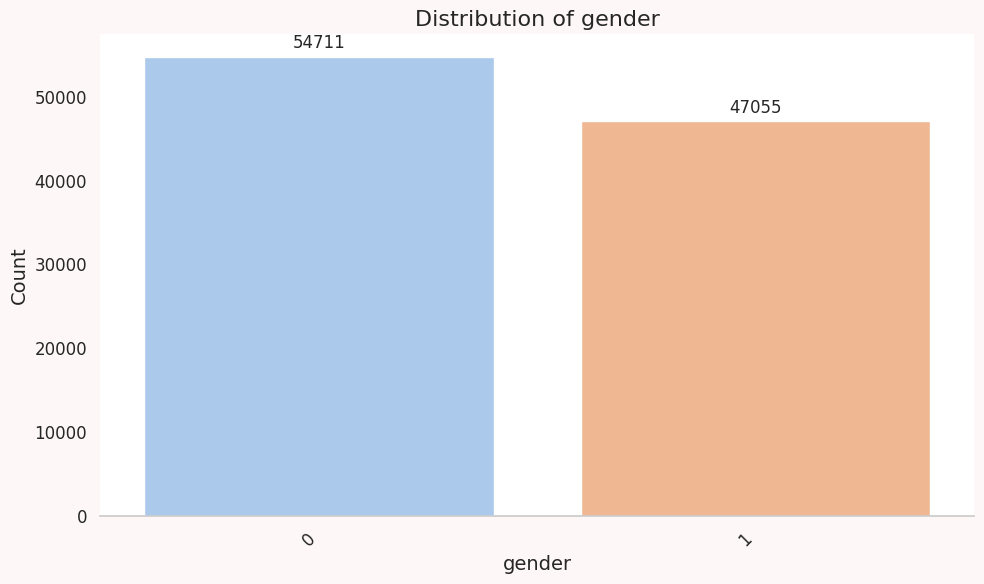

In [508]:
plot_feature_distribution(raw_data,'gender')
mapping = {"Female":0,"Male":1}
raw_data.gender = raw_data.gender.replace(mapping)
plot_feature_distribution(raw_data,'gender')

#### Admission type ID 

- Emergency : 1
- Urgent : 2
- Elective : 3
- Newborn : 4
- Not Available : 5
- NULL : 6
- Trauma Center : 7
- Not Mapped : 8

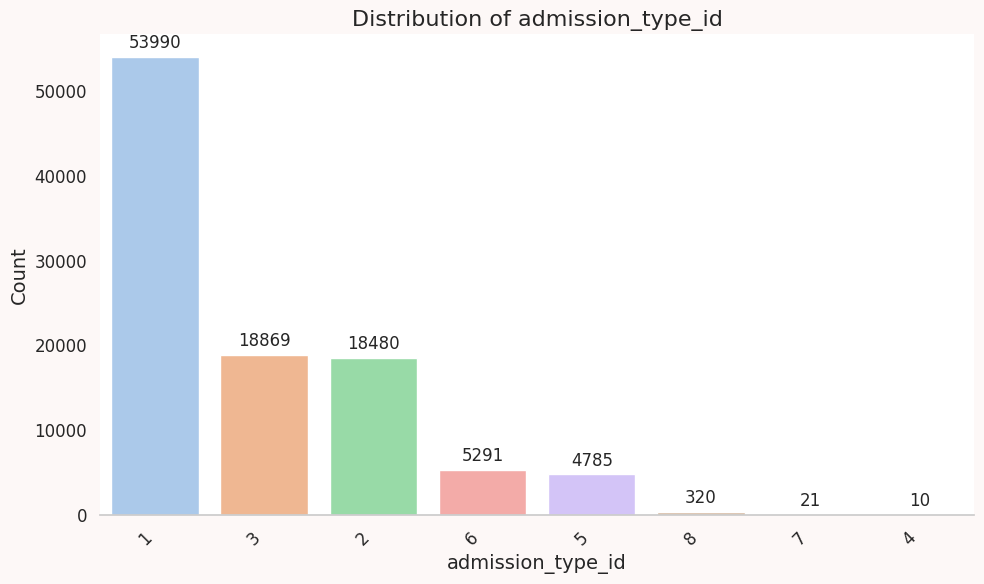

In [509]:
plot_feature_distribution(raw_data,'admission_type_id')

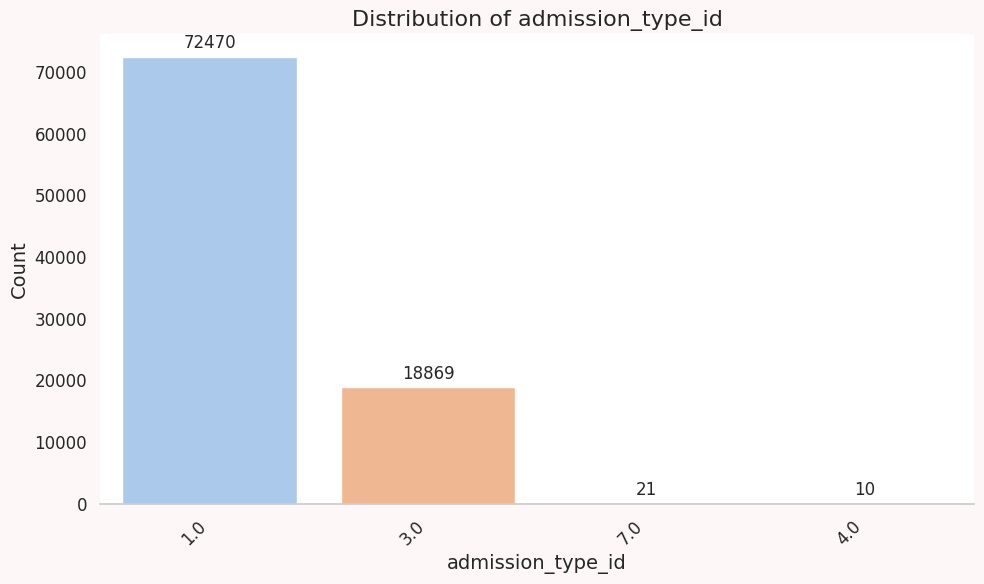

In [510]:

mapping = {2:1, 5:np.nan,6:np.nan,8:np.nan}
raw_data['admission_type_id'] = raw_data['admission_type_id'].replace(mapping)
plot_feature_distribution(raw_data,'admission_type_id')

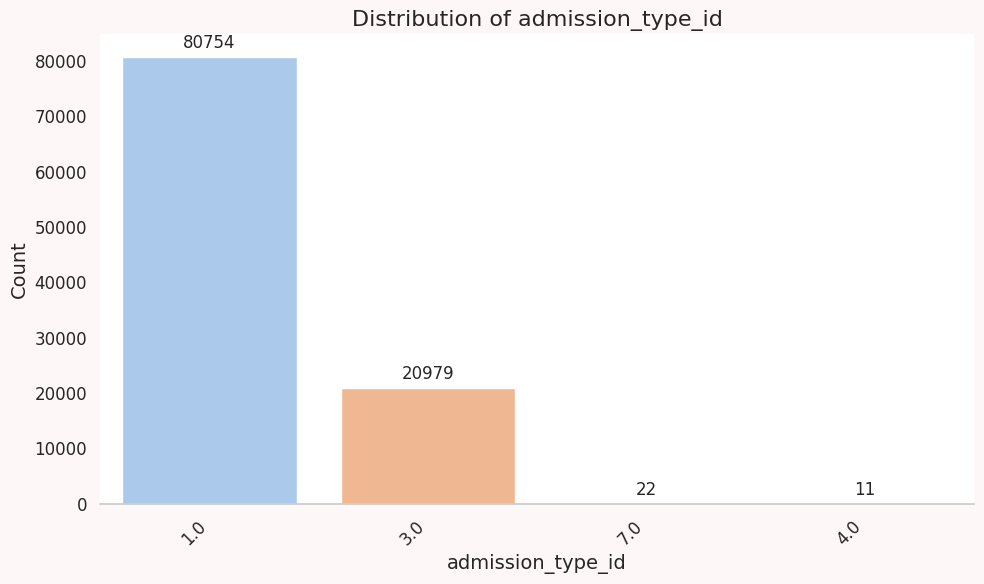

In [511]:

def fillna_distribution(df,col):
    #fill missing values acording to distribution of non_missing values 
    value_counts = df[col].value_counts(normalize=True)
    missing_mask = df[col].isnull()
    missing_count = missing_mask.sum()
    fill_values = np.random.choice(value_counts.index, size=missing_count, p=value_counts.values)
    df.loc[missing_mask, col] = fill_values
    df[col].value_counts(normalize=True)

fillna_distribution(raw_data,'admission_type_id')
plot_feature_distribution(raw_data,'admission_type_id')


#### Discharge Disposition ID

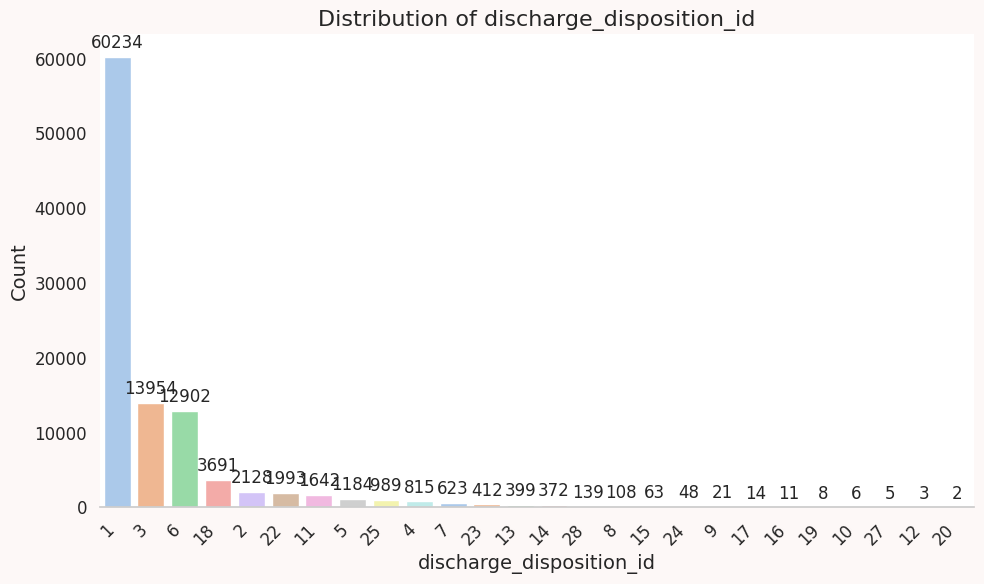

In [512]:
plot_feature_distribution(raw_data,'discharge_disposition_id')

Number of catergories:  26
Number of missing values:  14194


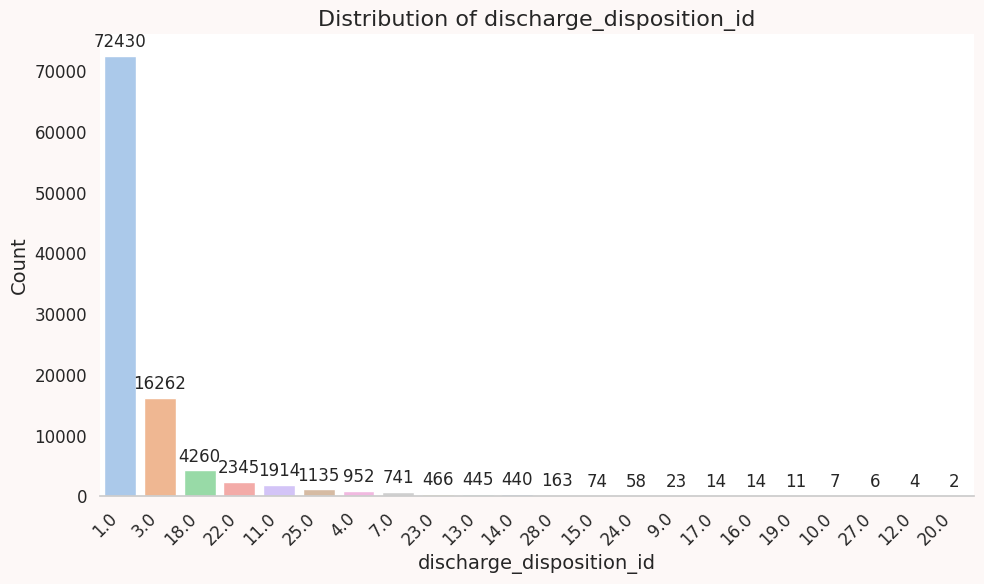

In [513]:
# fill nulls according to distribution of values
print('Number of catergories: ',len(raw_data['discharge_disposition_id'].unique()) )

mapping_nulls = {'Expired':np.nan,'Not Mapped':np.nan,'Unknown/Invalid':np.nan,'NULL':np.nan }
raw_data['discharge_disposition_id'] = raw_data['discharge_disposition_id'].replace(mapping)

print('Number of missing values: ',raw_data['discharge_disposition_id'].isnull().sum())
fillna_distribution(raw_data,'discharge_disposition_id')
plot_feature_distribution(raw_data,'discharge_disposition_id')


In [514]:
len(raw_data['discharge_disposition_id'].unique())
print('Number of catergories After filling null values: ',len(raw_data['discharge_disposition_id'].unique()) )


Number of catergories After filling null values:  22


#### Admission Source ID

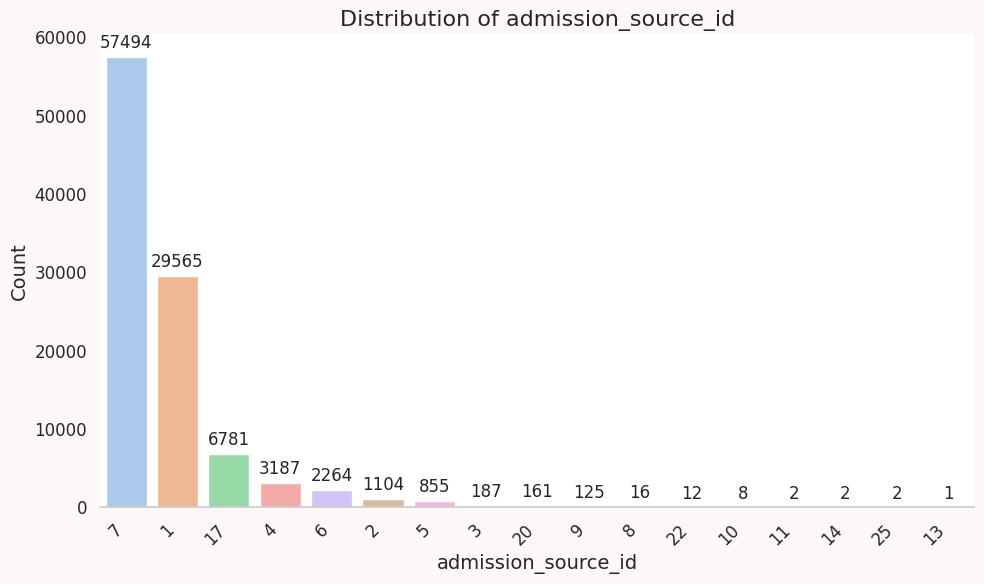

In [515]:
plot_feature_distribution(raw_data,'admission_source_id')

Number of missing values:  3135


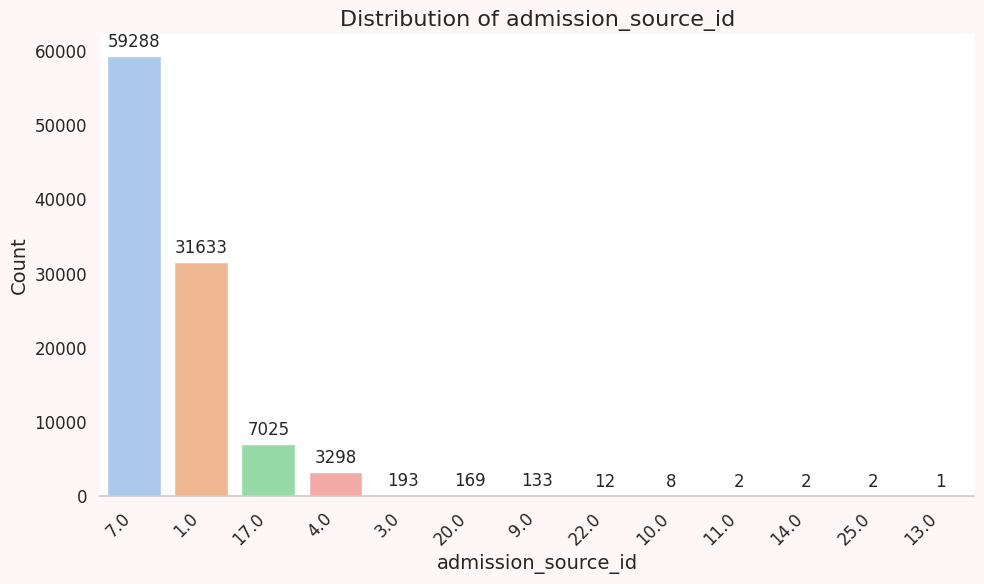

In [516]:
# fill nulls according to distribution of values
mapping_nulls = {'Expired':np.nan,'Not Mapped':np.nan,'Unknown/Invalid':np.nan,'NULL':np.nan ,'Not available':np.nan}
raw_data['admission_source_id'] = raw_data['admission_source_id'].replace(mapping)
print('Number of missing values: ',raw_data['admission_source_id'].isnull().sum())
fillna_distribution(raw_data,'admission_source_id')
plot_feature_distribution(raw_data,'admission_source_id')

#### Time in Hospital

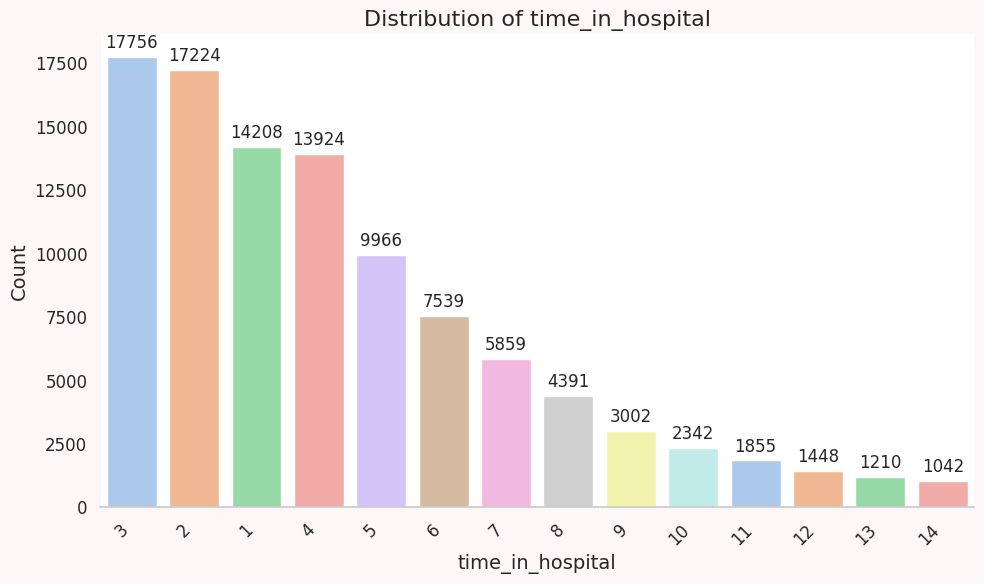

In [517]:
plot_feature_distribution(raw_data,'time_in_hospital')

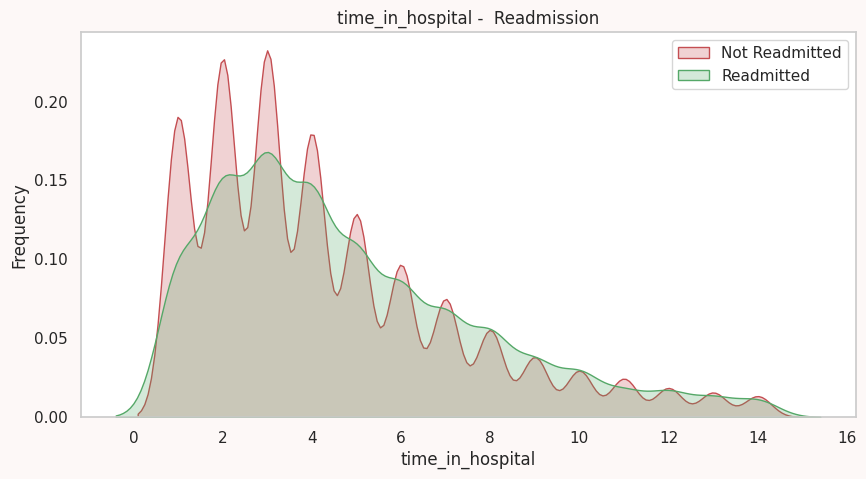

In [518]:
plot_prob_density(raw_data,'time_in_hospital')

#### Number of Procedures

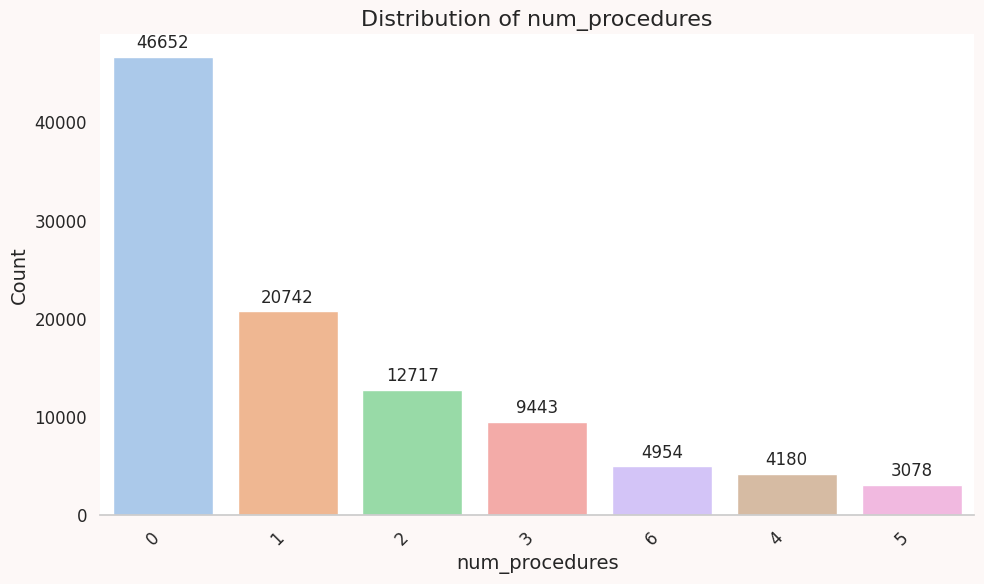

In [519]:
plot_feature_distribution(raw_data,'num_procedures')

#### Number of lab procedures

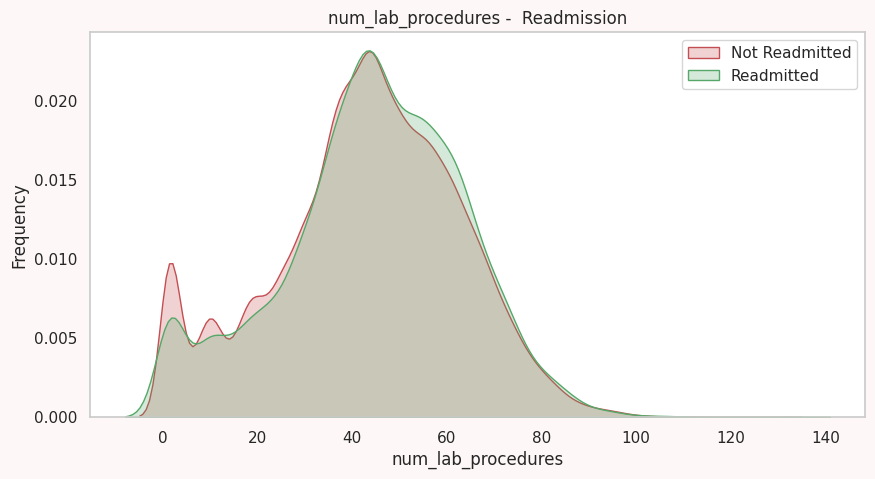

In [520]:
plot_prob_density(raw_data,'num_lab_procedures')

#### Number of Medications

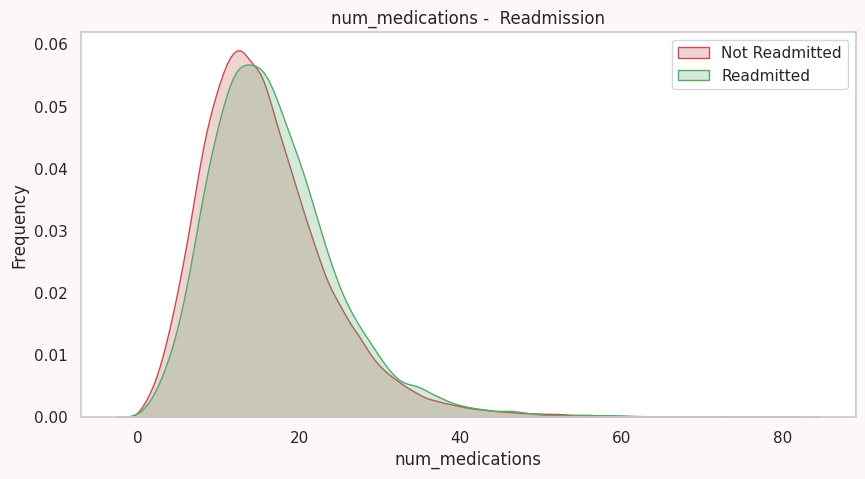

In [521]:
plot_prob_density(raw_data, 'num_medications') 

In [522]:
raw_data['num_medications']

0          1
1         18
2         13
3         16
4          8
          ..
101761    16
101762    18
101763     9
101764    21
101765     3
Name: num_medications, Length: 101766, dtype: int64

#### Diag1, Diag2 and Diag3

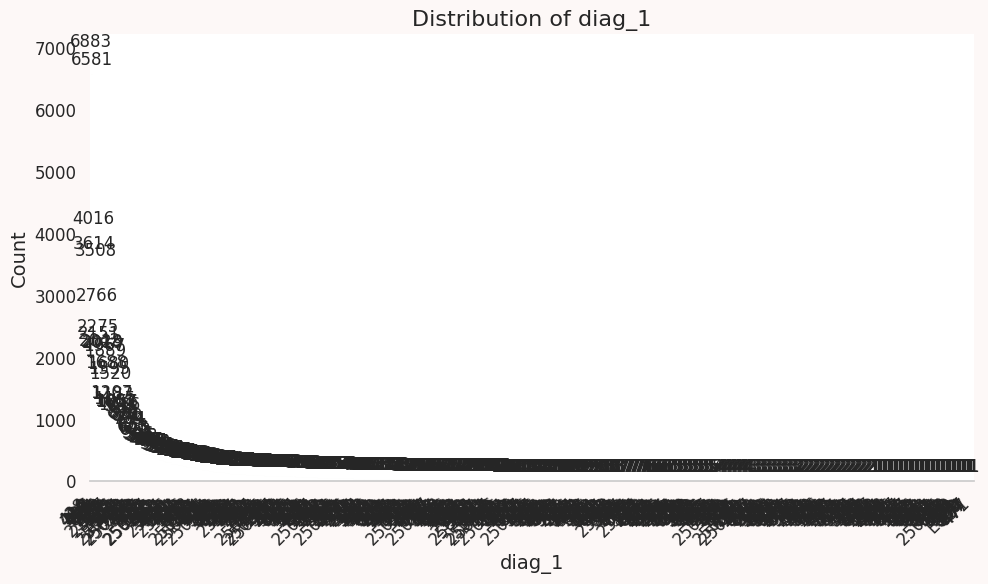

In [523]:
plot_feature_distribution(raw_data,'diag_1')

<>:3: DeprecationWarning: invalid escape sequence \d
<>:6: DeprecationWarning: invalid escape sequence \.
<>:17: DeprecationWarning: invalid escape sequence \d
<>:23: DeprecationWarning: invalid escape sequence \.
<>:3: DeprecationWarning: invalid escape sequence \d
<>:6: DeprecationWarning: invalid escape sequence \.
<>:17: DeprecationWarning: invalid escape sequence \d
<>:23: DeprecationWarning: invalid escape sequence \.
/tmp/ipykernel_7411/293658455.py:3: DeprecationWarning: invalid escape sequence \d
  circulatory = "^3[9-9]\d|4[0-5]\d|785$"
/tmp/ipykernel_7411/293658455.py:6: DeprecationWarning: invalid escape sequence \.
  Diabetes = "^250\.\d{1,2}|250$"
/tmp/ipykernel_7411/293658455.py:17: DeprecationWarning: invalid escape sequence \d
  "^(E|V)\d+",
/tmp/ipykernel_7411/293658455.py:23: DeprecationWarning: invalid escape sequence \.
  "^365\.\d{1,2}$"


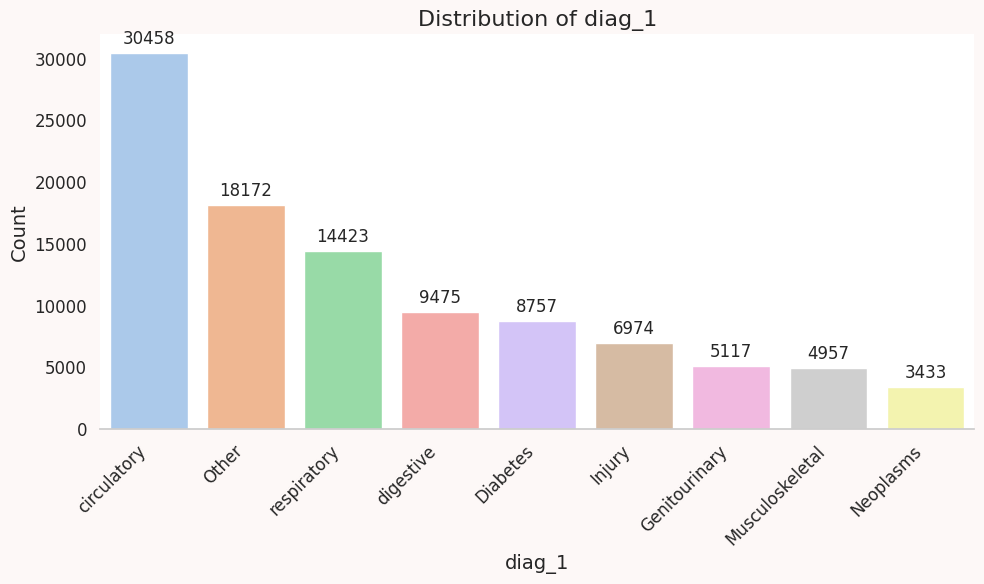

In [524]:
def diagnoses_categorization(col):
    # define the regular expression pattern to match ICD9 codes 
    circulatory = "^3[9-9]\d|4[0-5]\d|785$"
    respiratory = "^46[0-9]|4[7-9][0-9]|5[01][0-9]|786$"
    digestive = "^(52[0-9]|5[3-7][0-9]|787)$"
    Diabetes = "^250\.\d{1,2}|250$"
    Injury = "^(80[0-9]|8[1-9][0-9]|9[0-9]{2})$"
    Musculoskeletal = "^(71[0-9]|7[23][0-9])$"
    Genitourinary = "^(58[0-9]|59[0-9]|6[0-2][0-9]|788)$"
    Neoplasms =  "^(14[0-9]|1[5-9][0-9]|2[0-3][0-9])$"

    other = ["^(79[0-9]|780|781|784|789|783)$",
                "^(24[0-9]|25[1-9]|2[67][0-9])$",
                "^(68[0-9]|69[0-9]|70[0-9]|782)$",
                "^([1-9]|[1-9][0-9]|1[0-3][0-9])$",
                "^(29[0-9]|3[01][0-9])$",
                "^(E|V)\d+",
                "^(28[0-9])$" ,
                "^(32[0-9]|3[3-5][0-9])$",
                "^(63[0-9]|6[4-7][0-9])$",
                "^(36[0-9]|3[78][0-9])$",
                "^(74[0-9]|75[0-9])$",
                "^365\.\d{1,2}$"   
                ]


    cats = [circulatory,respiratory,digestive,Diabetes,Injury,Musculoskeletal,Genitourinary,Neoplasms]
    cats_names = ['circulatory','respiratory','digestive','Diabetes','Injury','Musculoskeletal','Genitourinary','Neoplasms']


    for i in range(len(cats)):  
       
        raw_data[col] = raw_data[col].str.replace(cats[i], cats_names[i], regex=True)

    for o in other:
        raw_data[col] = raw_data[col].str.replace(o, 'Other', regex=True)


diagnoses_categorization('diag_1')

plot_feature_distribution(raw_data,'diag_1')



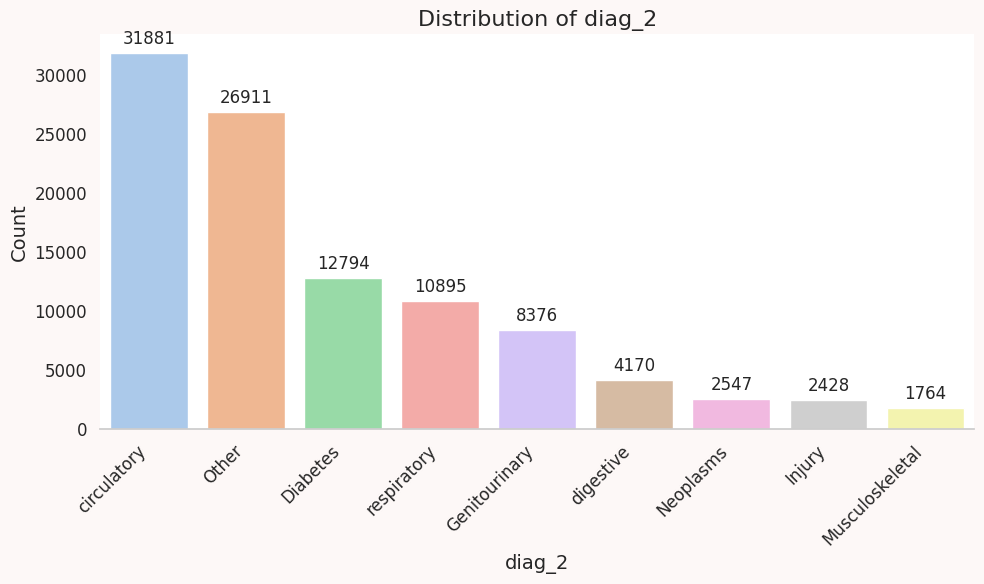

In [525]:
diagnoses_categorization('diag_2')
plot_feature_distribution(raw_data,'diag_2')

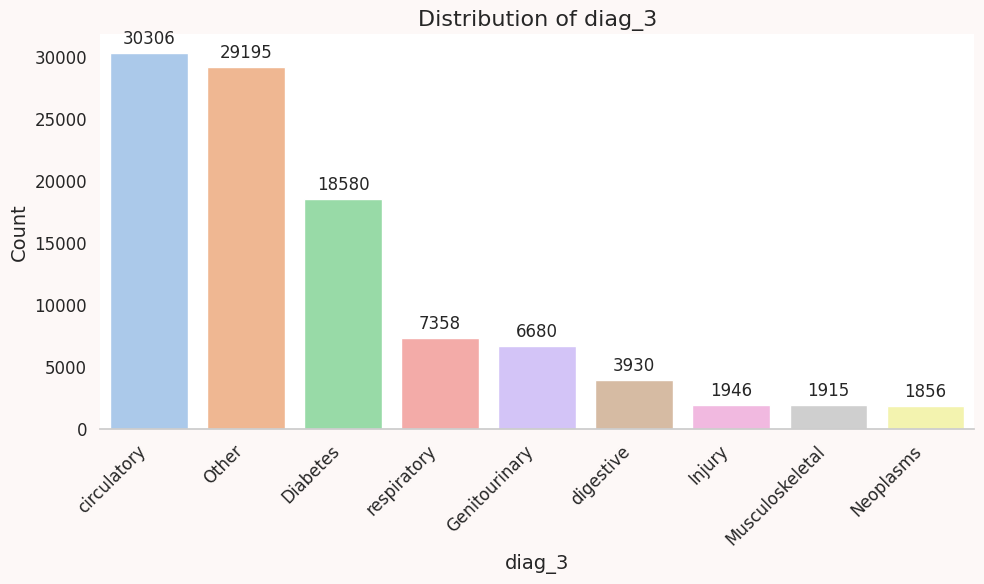

In [526]:
diagnoses_categorization('diag_3')
plot_feature_distribution(raw_data,'diag_3')

#### Change

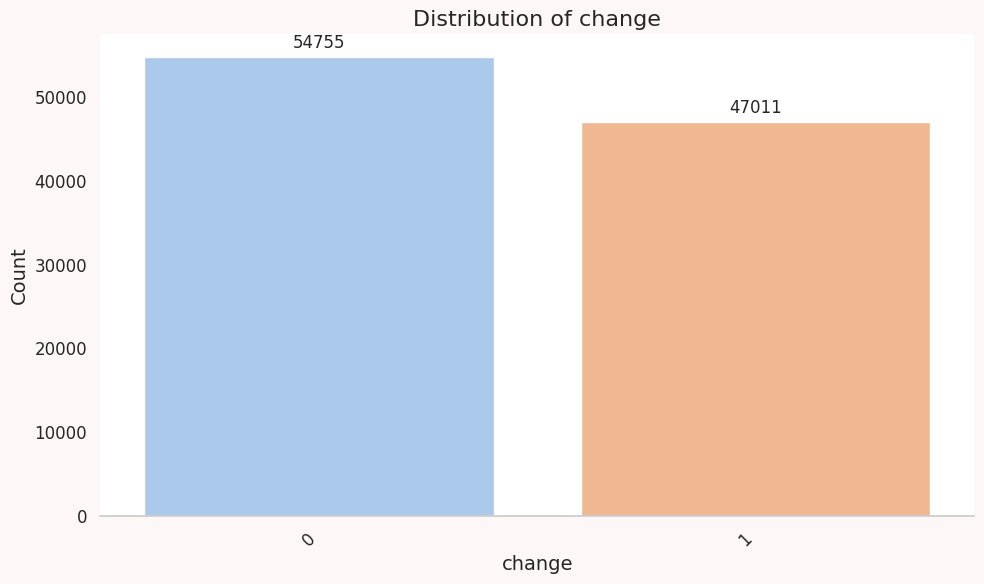

In [527]:
mapping = {'Ch':1,'No':0}
raw_data['change'] = raw_data['change'].replace(mapping)
plot_feature_distribution(raw_data,'change')


#### Glucose Serum Test Result

Indicates the range of the result or if the test was not taken.
Values:

- “>200,”
- “>300,”
- “normal,”
- “none” if not measured

remapped to :

- 1 : abnormal
- 0 : normal
- 2 : not_measured

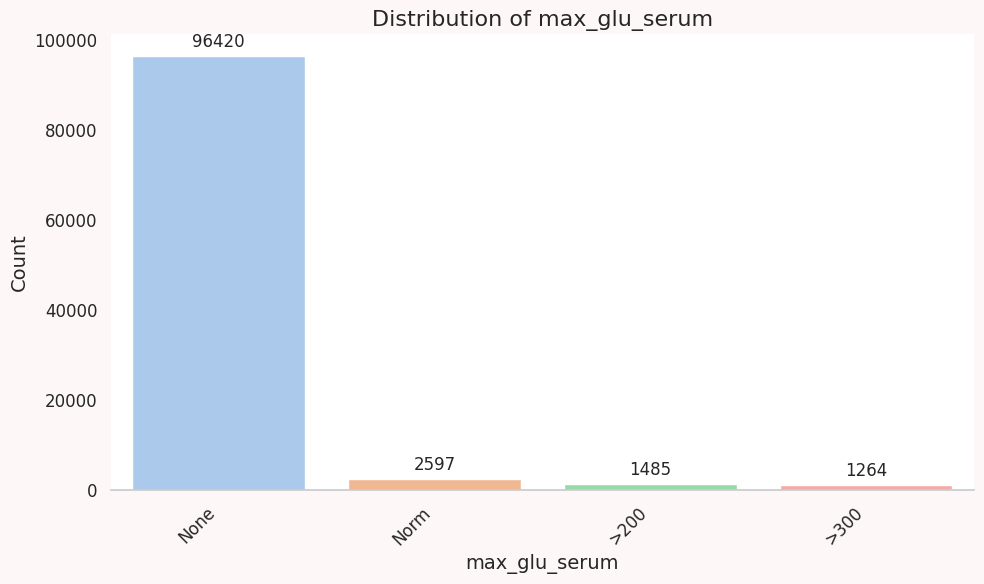

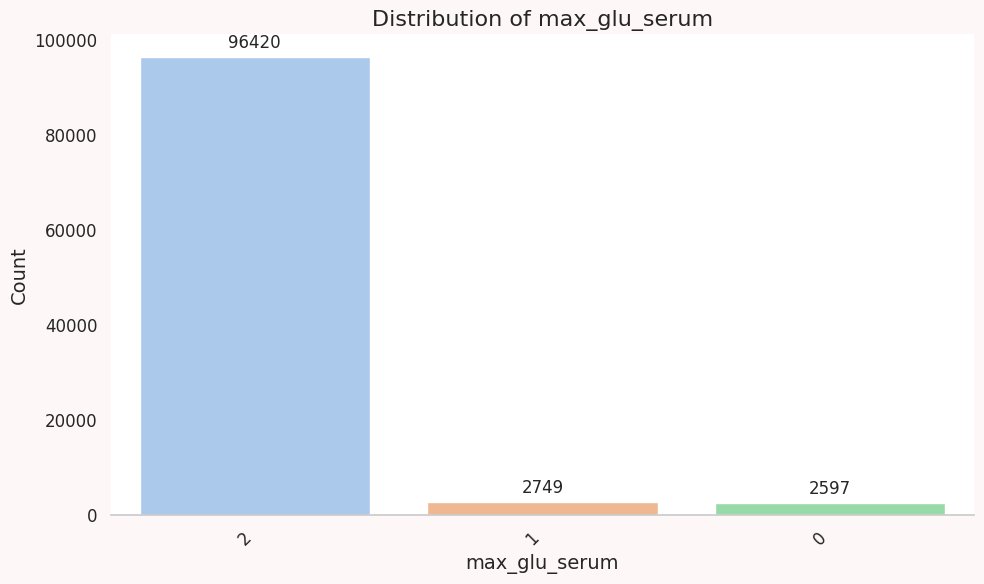

In [528]:


plot_feature_distribution(raw_data,'max_glu_serum')
mapping = {'>200':1,'>300':1,'Norm':0,'None':2}
raw_data.max_glu_serum = raw_data.max_glu_serum.replace(mapping)

plot_feature_distribution(raw_data,'max_glu_serum')


#### A1c test result¶



Indicates the range of the result or if the test was not taken.

- “>8” if the result was greater than 8%,
- “>7” if the result was greater than 7% but less than 8%, “normal”
- if the result was less than 7%, and “none” if not measured.

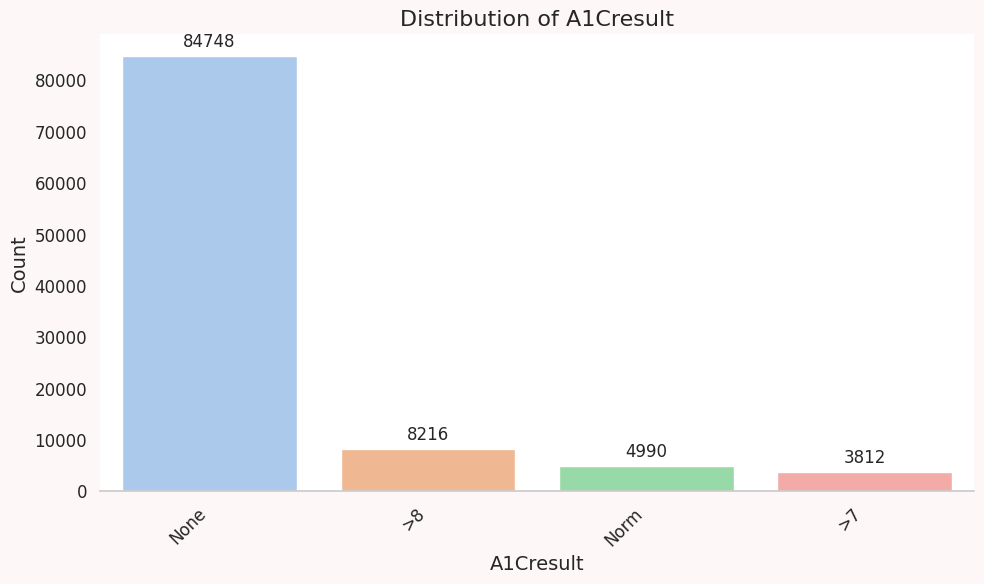

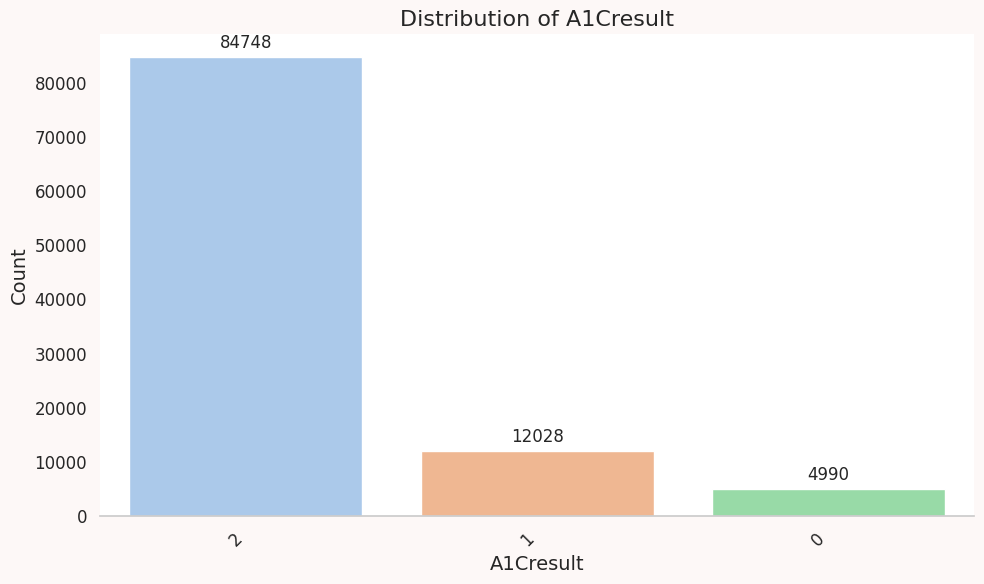

In [529]:
plot_feature_distribution(raw_data,'A1Cresult')
mapping = {'>8':1,'>7':1,'Norm':0,'None':2}
raw_data.A1Cresult = raw_data.A1Cresult.replace(mapping)
plot_feature_distribution(raw_data,'A1Cresult')

#### Diabetes medications¶

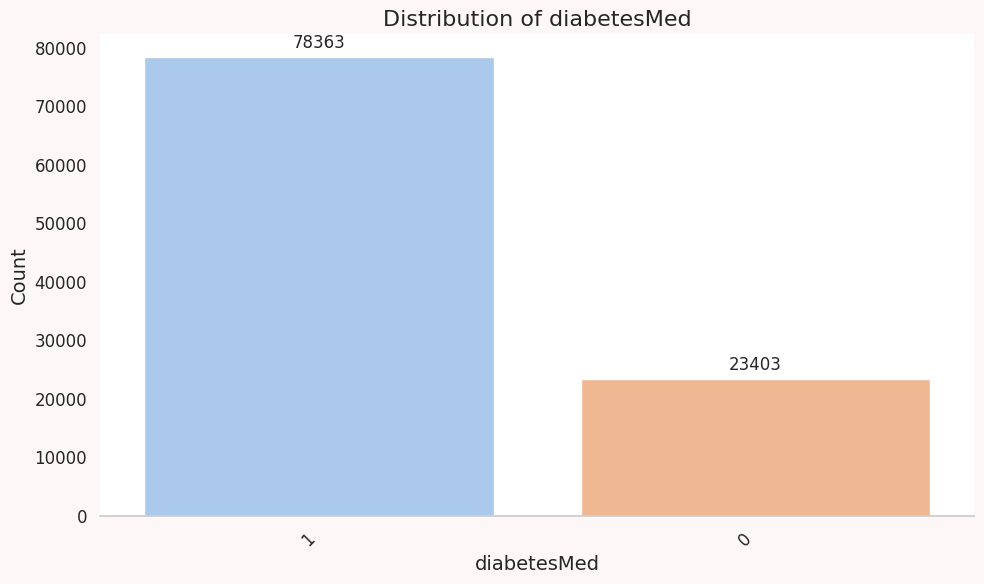

In [530]:
mapping = {'Yes':1,'No':0}
raw_data['diabetesMed'] = raw_data['diabetesMed'].replace(mapping)
plot_feature_distribution(raw_data,'diabetesMed')

#### Number of diagnoses

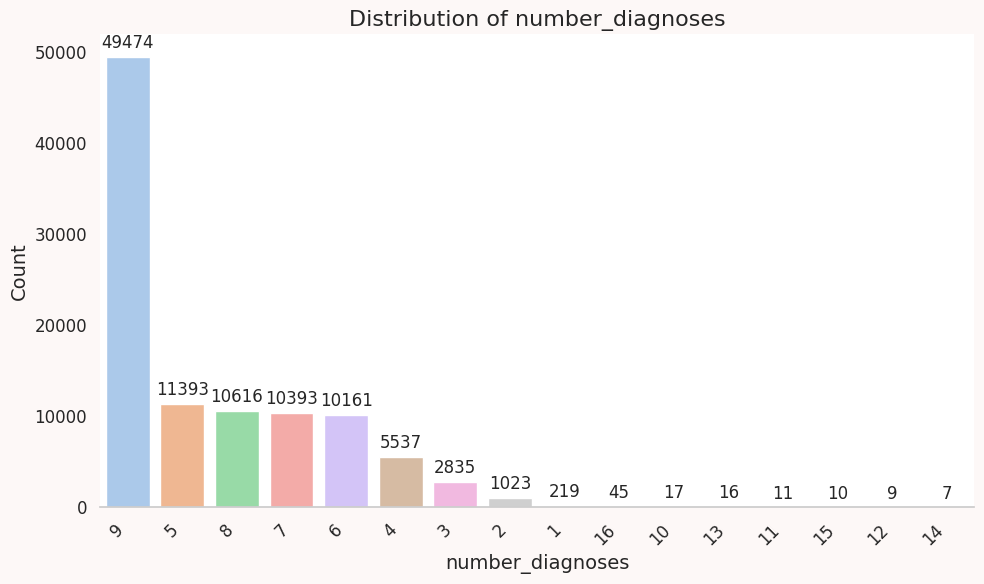

In [531]:
plot_feature_distribution(raw_data,'number_diagnoses')

#### Number of emergency visits 


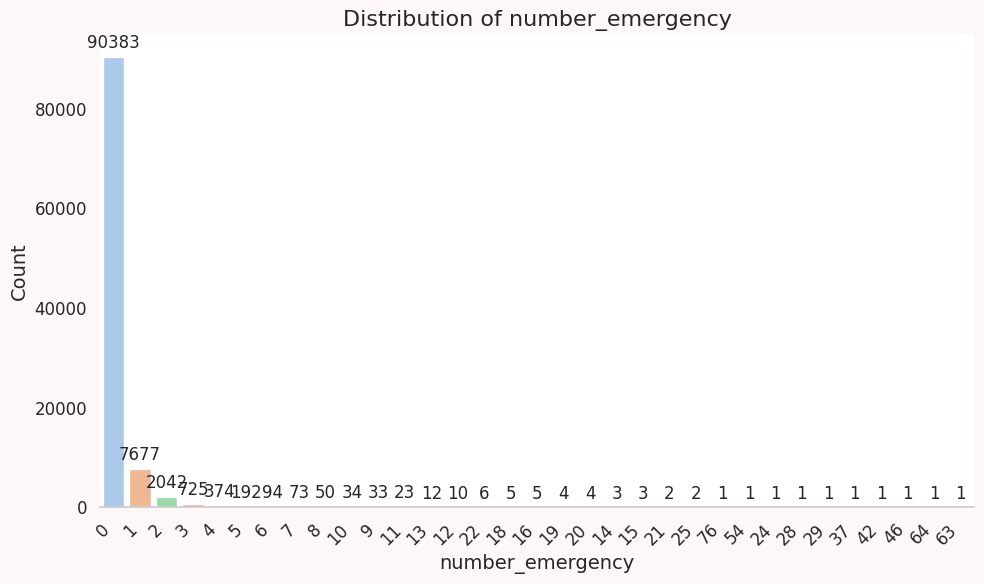

In [532]:
plot_feature_distribution(raw_data,'number_emergency')

####  Hospital visits 

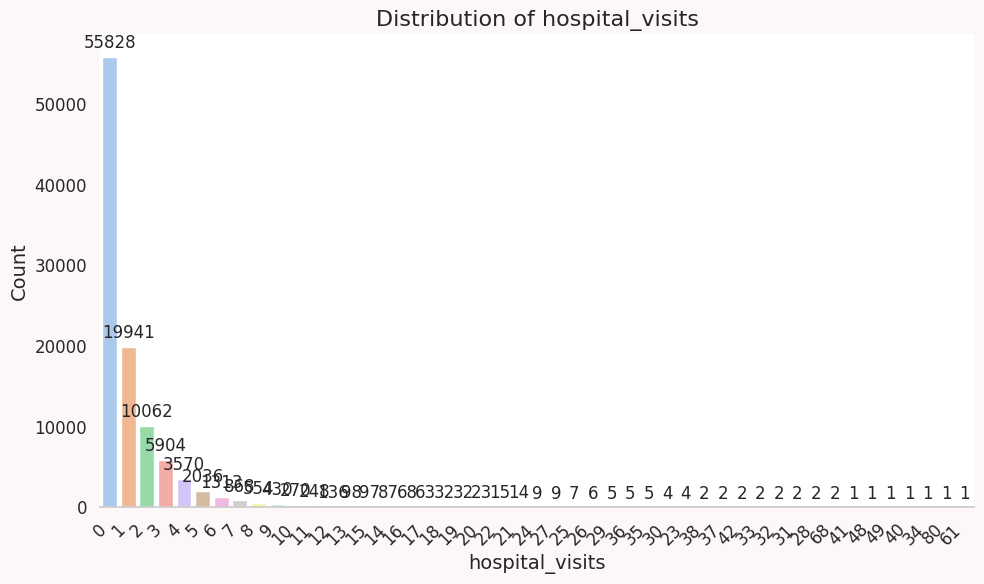

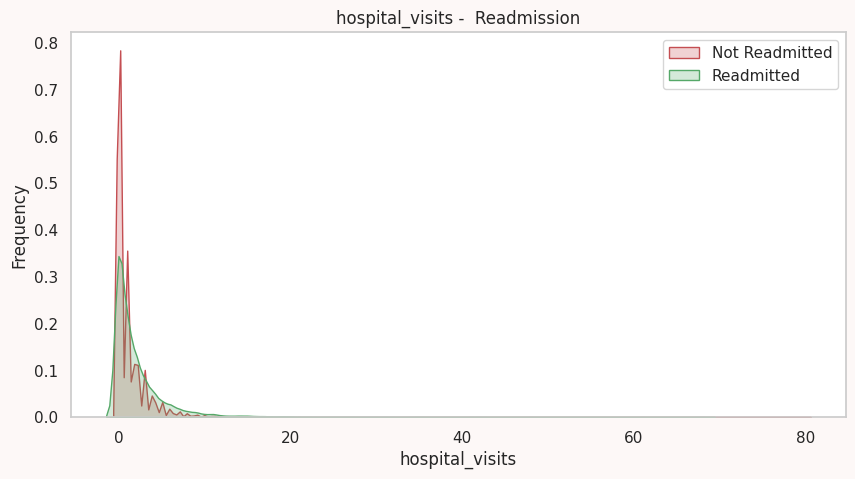

In [533]:
raw_data['hospital_visits'] = raw_data['number_outpatient'] + raw_data['number_emergency'] + raw_data['number_inpatient']

plot_feature_distribution(raw_data,'hospital_visits')
plot_prob_density(raw_data,'hospital_visits')

#### 23 columns for different medications

In [534]:
meds = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'citoglipton',
'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone',
'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'insulin',
'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone','metformin-rosiglitazone','metformin-pioglitazone']


med_values_map = {'No': 0, 'Steady': 0, 'Up': 1, 'Down': -1}
raw_data[meds] = raw_data[meds].replace(med_values_map) 


adf = raw_data[meds]
increases = adf[adf > 0].abs().sum(axis=1)
raw_data['num_increased_meds'] = increases
decreases = adf[adf < 0].abs().sum(axis=1)
raw_data['num_decreased_meds'] = decreases


#med_values_diff = raw_data[meds].diff(axis=1)
#med_changes = med_values_diff.ne(0).sum(axis=1)
#raw_data['num_med_changes'] = med_changes
#meds_df = raw_data[meds]

#raw_data = raw_data.drop(meds,axis=1)
#print(len(raw_data.columns))



In [535]:
raw_data['num_increased_meds'].value_counts()

0.0    87521
1.0    13658
2.0      554
3.0       33
Name: num_increased_meds, dtype: int64

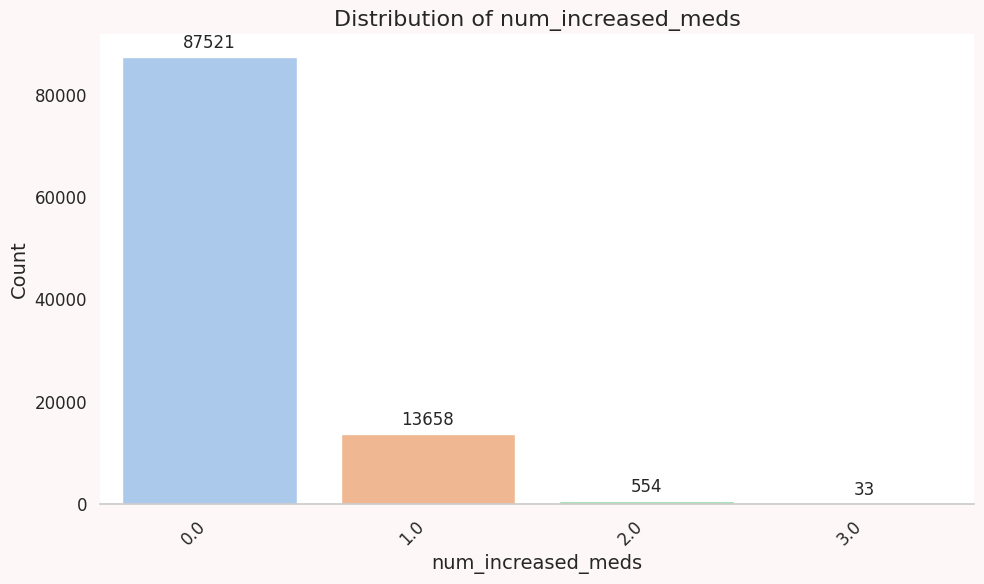

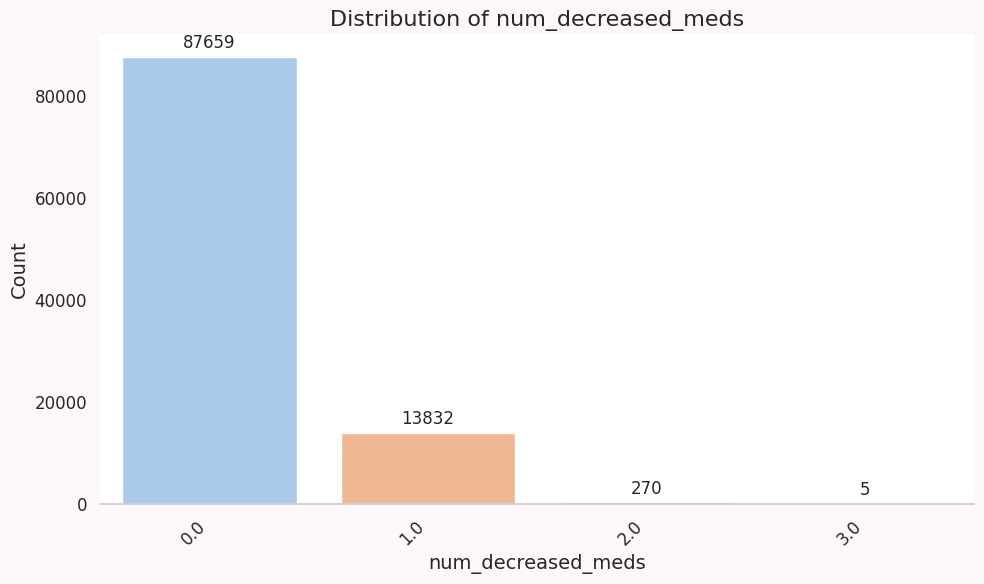

In [536]:
plot_feature_distribution(raw_data,'num_increased_meds')
plot_feature_distribution(raw_data,'num_decreased_meds')

#### Identification columns 

### Influence of the different variables on the Target variable :


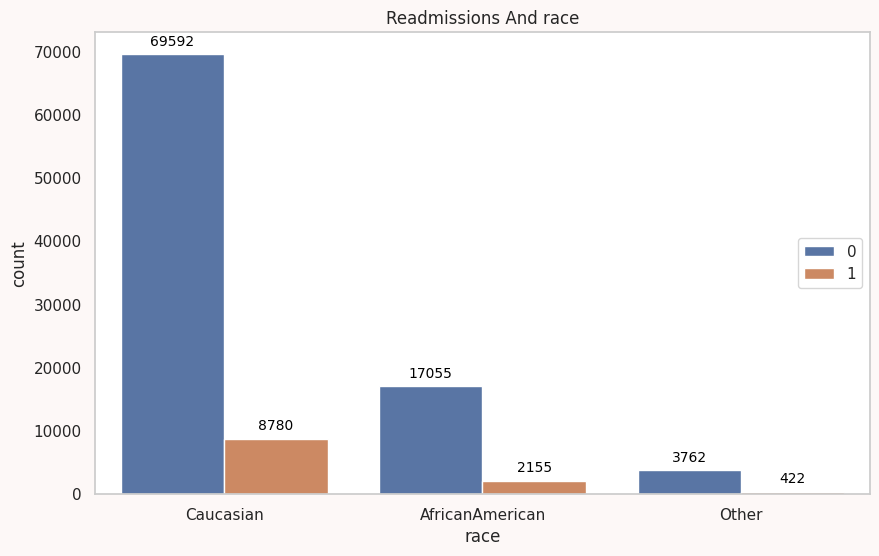

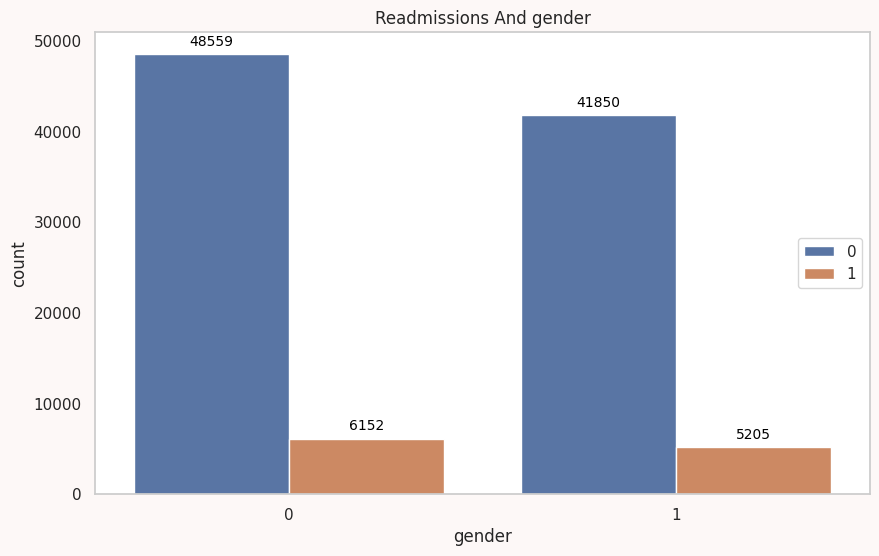

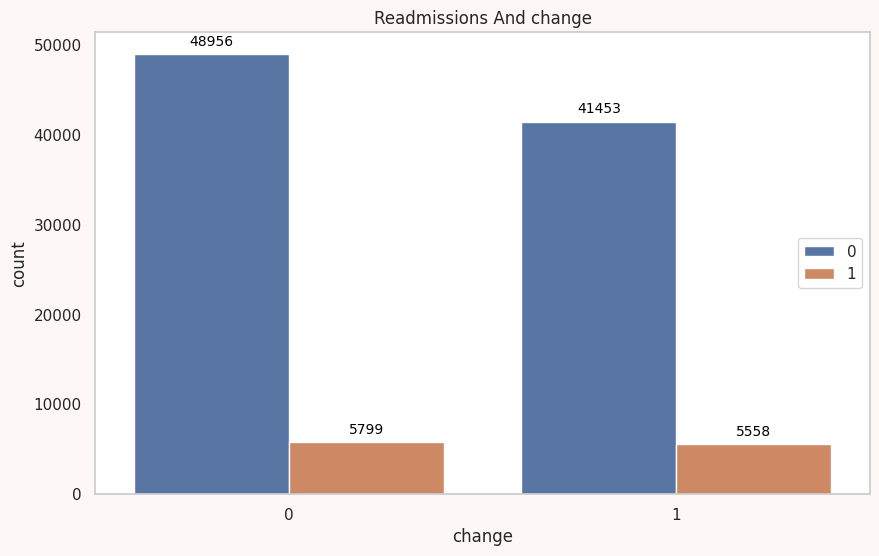

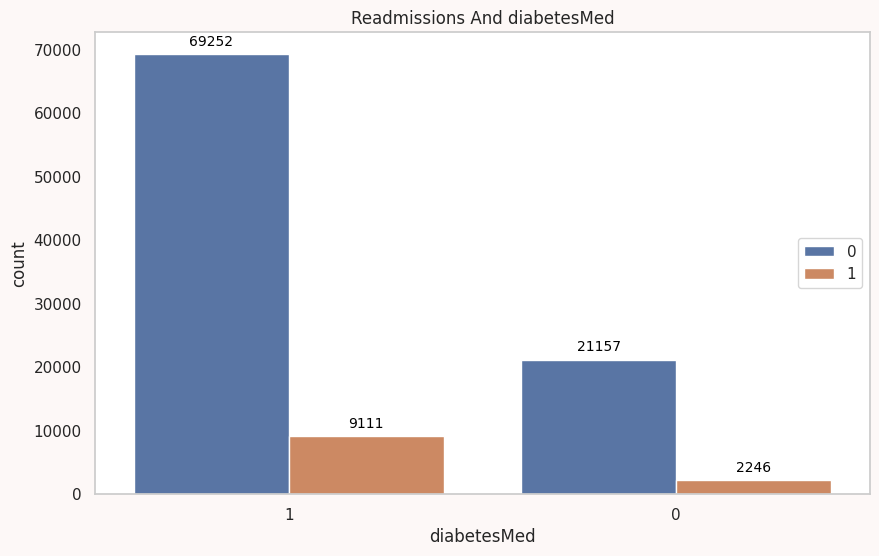

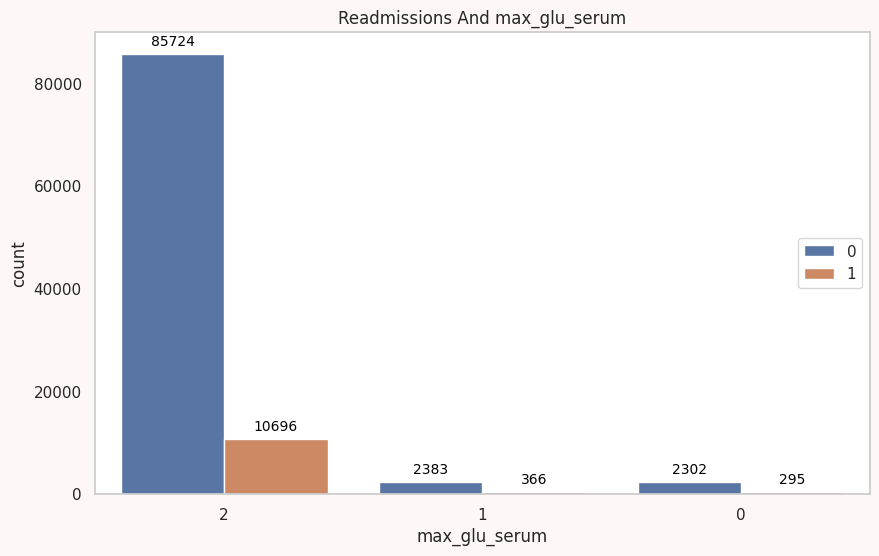

Text(0.5, 1.0, 'Readmission And Number of lab procedures')

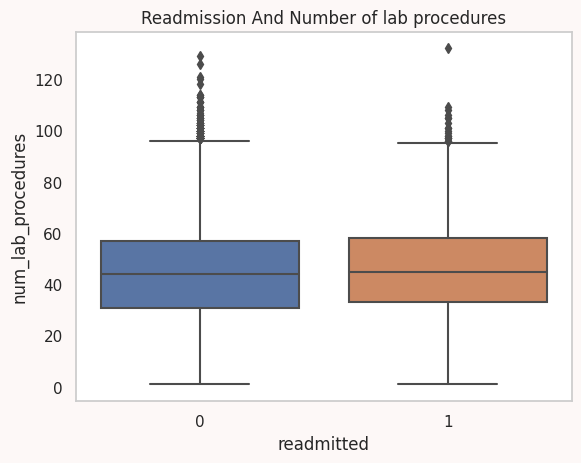

In [537]:
def plot_readmission_correlations(df,col):
    col_readmitted_group = raw_data.groupby([col,'readmitted']).readmitted.count()
    col_data = raw_data[col].unique().tolist()
    readmission = raw_data.readmitted.unique().tolist()
    
    readmitted = []
    for i in col_data:
        for j in readmission:
            if j == 1 :
                readmitted.append(col_readmitted_group[i][j])
            
    order = pd.DataFrame({'col': col_data, 'readmitted':readmitted}).sort_values(by='readmitted',ascending=False).col.tolist()
    
    #plot
    fig, ax =plt.subplots(figsize=(10,6))
    sns.countplot(x=col, hue="readmitted", data=raw_data, palette="deep" ,order = order)
    
    ax.set_title('Readmissions And '+ col)
    ax.legend(loc='right')

    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height:.0f}', (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom', fontsize=10, color='black', xytext=(0, 4),
                    textcoords='offset points')
    plt.show()
     
    
plot_readmission_correlations(raw_data,"race")
plot_readmission_correlations(raw_data,"gender")
#plot_readmission_correlations(raw_data,"insulin")
plot_readmission_correlations(raw_data,"change")
plot_readmission_correlations(raw_data,"diabetesMed")
plot_readmission_correlations(raw_data,"max_glu_serum")

sns.boxplot(x="readmitted", y="num_lab_procedures", data=raw_data).set_title('Readmission And Number of lab procedures')


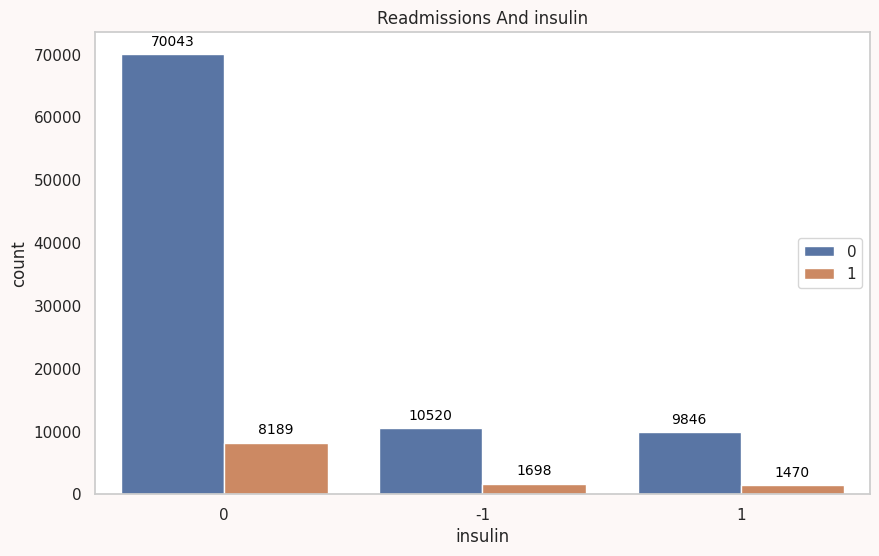

In [538]:
plot_readmission_correlations(raw_data,"insulin")

# Pre-modelling

### utility functions

In [539]:
def visualize_column_skewness(data,col):
    # Create the histoplot with seaborn
    data = data[col]
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.histplot(data=data, kde=True, color='#ffa600', edgecolor='white', linewidth=1.2, ax=ax)
    # Add vertical lines for median and mean
    median = np.median(data)
    mean = np.mean(data)
    ax.axvline(x=median, linestyle='--', color='#58508d', label='Median', linewidth=1.5)
    ax.axvline(x=mean, linestyle='--', color='#bc5090', label='Mean', linewidth=1.5)

    # Add labels and title
    ax.set_xlabel('Value', fontsize=14)
    ax.set_ylabel('Frequency', fontsize=14)
    ax.set_title('Skewness of variable '+col, fontsize=18)
    # Add legend
    ax.legend(fontsize=14)
    # Remove top and right spines
    sns.despine(top=True, right=True)
    plt.show()


def bar_plot(df,skews,features):
    # Create the bar plot with seaborn
    sns.set_style("whitegrid")
    sns.set_palette("husl")
    
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.barplot(x=skews, y=features, data=df, ax=ax,linewidth = 1)

    # Add labels and title
    ax.set_xlabel(skews, fontsize=14)
    ax.set_ylabel(features, fontsize=14)
    ax.set_title(skews+' distribution', fontsize=18)

    # Add legend
    handles, labels = ax.get_legend_handles_labels()
    #ax.legend(handles, skews, title='Skewness', fontsize=12)
    ax.legend(labels,loc="best")

     # Add bar values
    for rect in ax.patches:
        width = rect.get_width()

        if width > 0: 
            xpos = width-1
        else :
            xpos = width+1

        height = rect.get_y()
        ypos = height + 0.6
        ax.text(width, ypos, f'{width:.2f}', ha='center', va='bottom')
    # Remove top and right spines
    sns.despine(top=True, right=True)

    plt.show()


def visualize_data_skewness(data,numerical_features):
    skew_vals = [ data[i].skew() for i in numerical_features]
    df = pd.DataFrame( {'features': numerical_features, 'Skewness':skew_vals }).sort_values(by='Skewness',ascending = False).reset_index(drop=True) 
    bar_plot(df,'Skewness','features')


def visualize_data_kurtosis(data,numerical_features):
    skew_vals = [ data[i].kurtosis() for i in numerical_features]
    df = pd.DataFrame( {'features': numerical_features, 'Kurtosis':skew_vals }).sort_values(by='Kurtosis',ascending = False).reset_index(drop=True) 
    bar_plot(df,'Kurtosis','features')


def remove_skewness_kurtosis(data, num_cols):
    for col in num_cols:
        if abs(data[col].skew()) > 2:
            data[col] = pd.Series(data[col]+0.001)
            transformed_data = boxcox(data[col],lmbda=0)
            data[col] = transformed_data - 0.001


In [540]:

non_numerical_features = list(raw_data.select_dtypes(exclude=['number']).columns)
admission_discharge_features = ['admission_type_id','discharge_disposition_id','admission_source_id']
identification_features = ['encounter_id','patient_nbr']

#remove binary features, patient identificatation features as well as admission and discharge features
numerical_features = list(raw_data.select_dtypes(include=['number']).columns)
numerical_features = list(filter(lambda x : x not in identification_features and x not in admission_discharge_features, numerical_features))
numerical_features = list(filter(lambda x : len(raw_data[x].unique()) > 3 , numerical_features))


### skewness, kurtosis 

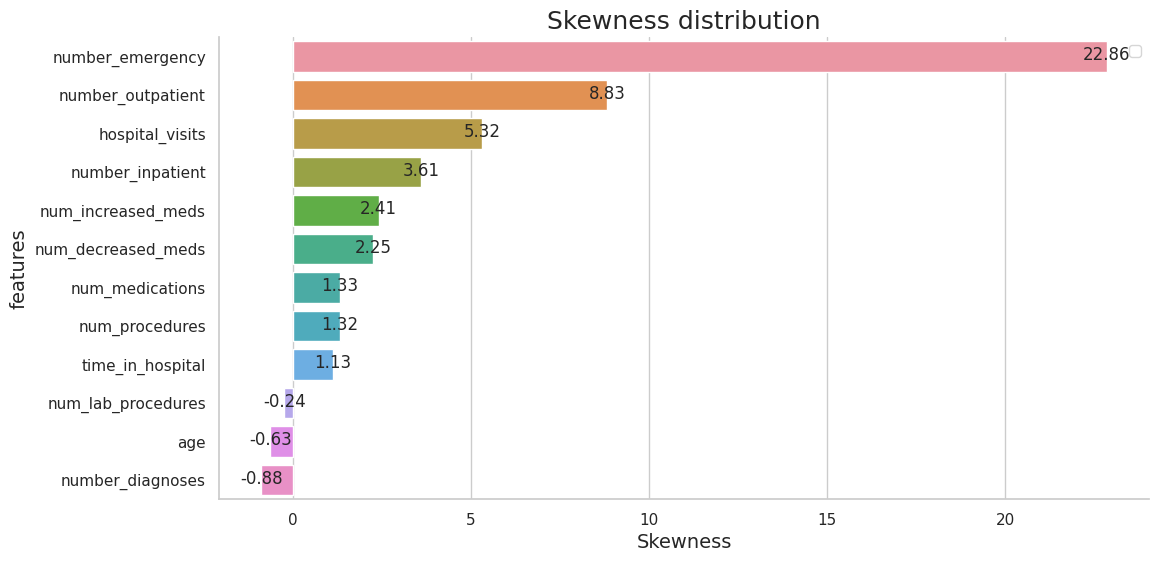

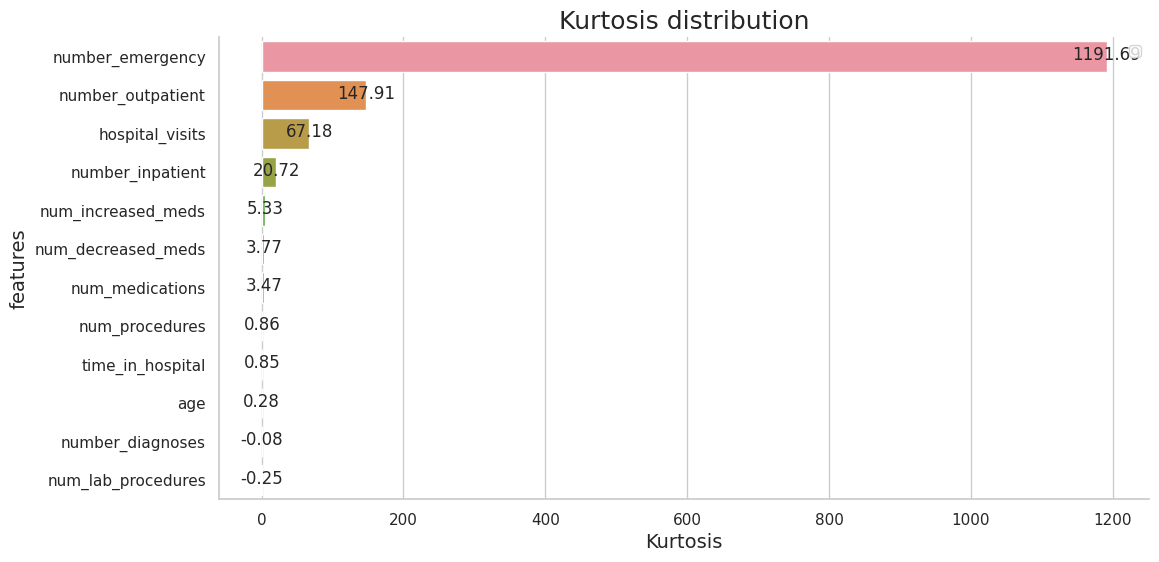

In [541]:
visualize_data_skewness(raw_data,numerical_features)
visualize_data_kurtosis(raw_data,numerical_features)

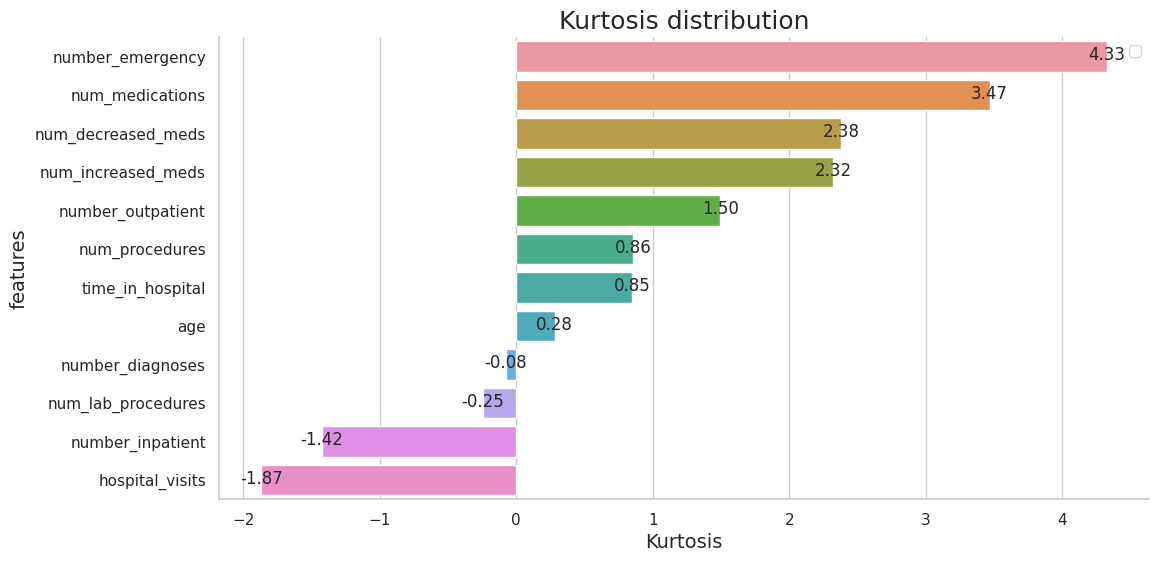

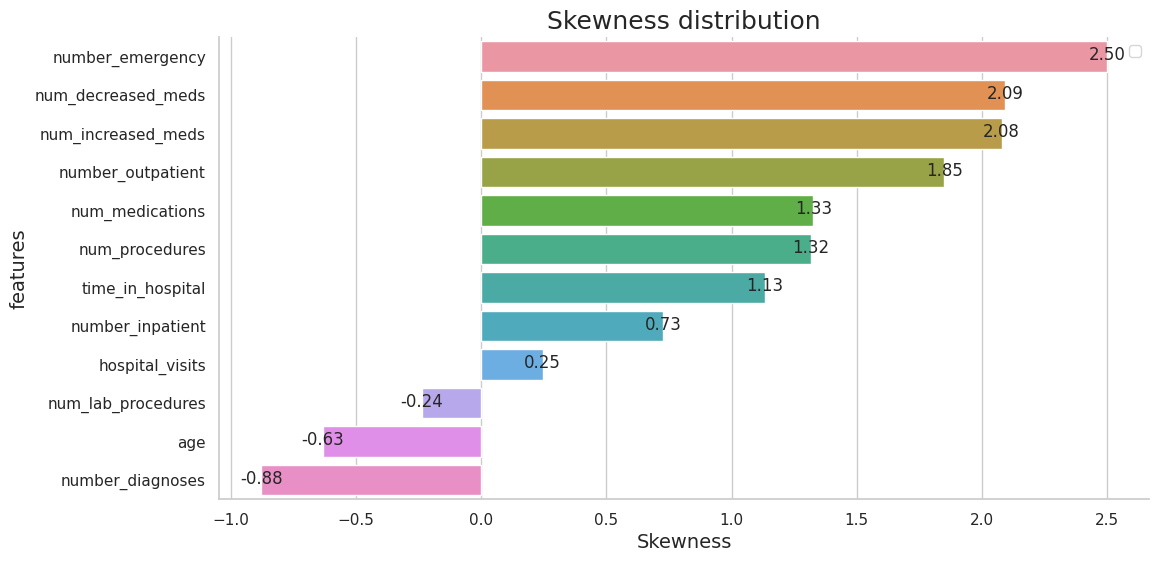

In [569]:
data = raw_data.copy(deep=True)
remove_skewness_kurtosis(data,numerical_features )
visualize_data_kurtosis(data,numerical_features)
visualize_data_skewness(data,numerical_features)

### on-hot encoding, train test split, upsampling,scaling, dropping multiple encounters 

In [570]:
# Perform one-hot encoding to categorical columns 
encoded_df = pd.get_dummies(data, columns=non_numerical_features)
# Replace original columns with encoded columns
data = encoded_df

## drop multiple encounters 
data = data.drop_duplicates(subset= ['patient_nbr'], keep = 'first')


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f05abe85940>
Traceback (most recent call last):
  File "/home/mahmud/.local/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/mahmud/.local/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/mahmud/.local/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/mahmud/.local/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


(42910, 75)


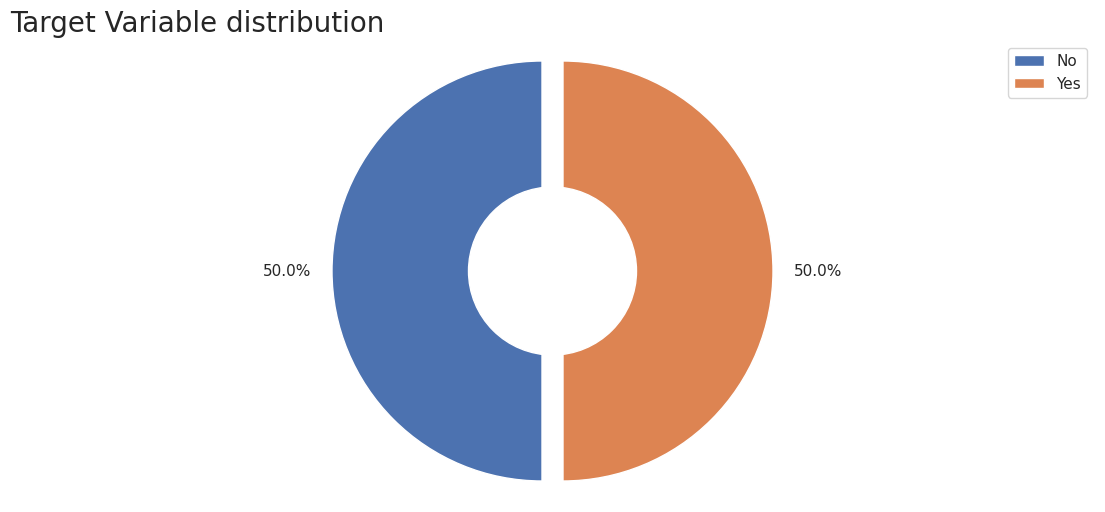

In [571]:

X = data.drop('readmitted',axis = 1)
y = data['readmitted']


# upsampling 
sm = SMOTE(random_state=20)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=43)

print(X_train.shape)


X_train, y_train = sm.fit_resample(X_train, y_train)

# create an instance of the StandardScaler class
scaler = StandardScaler()

X_train_scaled  = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# Create a new DataFrame with the scaled data
X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X_train.columns)

#### plot target variable 
values = y_train.value_counts().tolist()
legend = ['No','Yes']
labels = [ str(round((value / len(y_train) * 100),2))+'%' for value in values] 
df = pd.DataFrame({'Values' :values, 'labels' :labels })
pie_chart_plotter(df ,'labels', 'Values','Target Variable distribution',labels,legend)


### Multicolinearity analysis 

In [572]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF values
vif = pd.DataFrame()
vif["Variable"] = X_train.columns
vif["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]


/home/mahmud/.local/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


In [573]:
index = vif[vif.VIF > 5].index.tolist()

correlation_matrix = data.drop('readmitted',axis = 1).corr()


In [574]:
cols = []
for col in correlation_matrix.columns:
    subdf = correlation_matrix.drop(col)
    if (subdf[col].max() > 0.6) :
        cols.append(col)

corrs = correlation_matrix.loc[cols,cols]

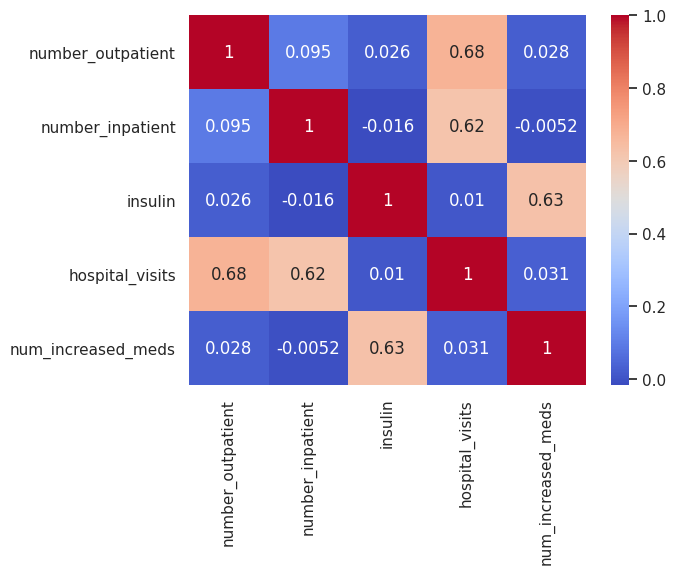

In [575]:
sns.heatmap(corrs, annot=True, cmap="coolwarm")
plt.show()

# Modeling

### Logistic Regression

In [576]:
# logistic regression model with Ridge regularization
ridge_logreg = LogisticRegression(penalty='l2', solver='liblinear', C=1.0)
ridge_scores = cross_val_score(ridge_logreg, X_train, y_train, cv=5)  # Perform 5-fold cross-validation

# Train the model on the full training set
ridge_logreg.fit(X_train, y_train)

# Make predictions on the test set
y_pred = ridge_logreg.predict(X_test)

# Calculate the accuracy score on the test set
l_accuracy = accuracy_score(y_test, y_pred)

# Print cross-validation accuracy and test set accuracy
print('Cross-Validation Accuracy:', ridge_scores.mean())
print('Test Set Accuracy:', l_accuracy)


Cross-Validation Accuracy: 0.9480264683606858
Test Set Accuracy: 0.9116680648769575


### Decision Tree

In [577]:
clf = DecisionTreeClassifier(max_depth=100, criterion = "gini", min_samples_split=200)
clf.fit(X_train, y_train)
# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the model's accuracy
d_accuracy = clf.score(X_test, y_test)


### Randomn Forrest

In [578]:

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 25, 50],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}


# Create a random forest classifier
#rf = RandomForestClassifier(criterion='gini')

# Create the GridSearchCV object
#grid_search = GridSearchCV(rf, param_grid, cv=5)

# Fit the GridSearchCV object to the training data
#grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = {'criterion': 'gini',
 'max_depth': 50,
 'min_samples_split': 2,
 'n_estimators': 200}

# Create a new random forest classifier with the best hyperparameters
rf_best = RandomForestClassifier(**best_params)

# Train the classifier on the training data
rf_best.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_best.predict(X_test)

r_accuracy = rf_best.score(X_test, y_test)


### XGboost

In [579]:

xb = XGBClassifier(n_estimators=200, learning_rate=0.1, random_state=42)
xb.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xb.predict(X_test)

# Evaluate the model's accuracy
x_accuracy = xb.score(X_test, y_test)


# results

### Model comparison

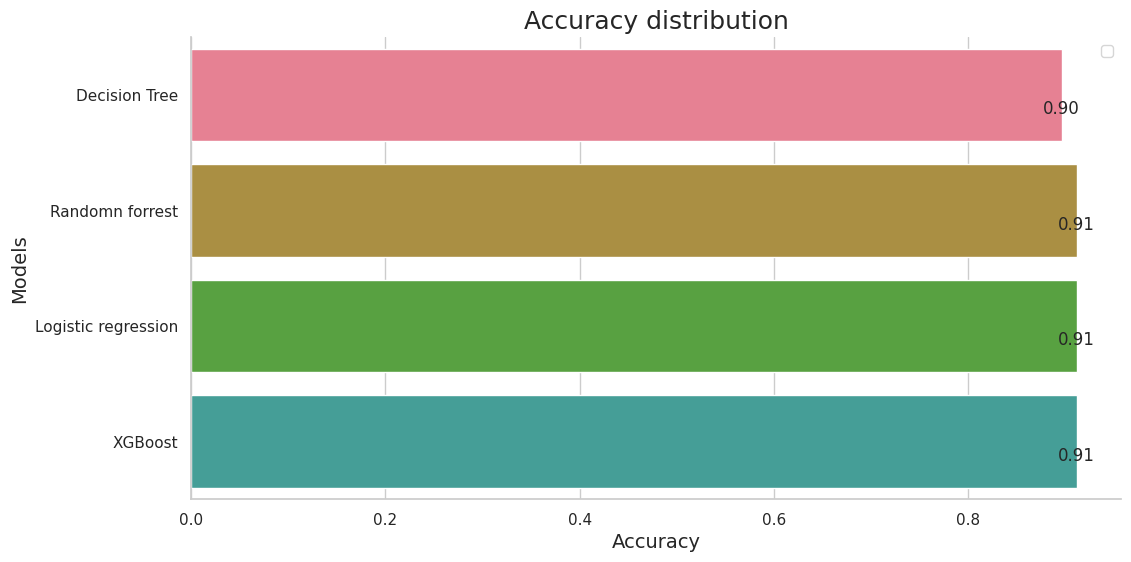

In [580]:
models = ['Logistic regression','Decision Tree', 'Randomn forrest','XGBoost']
accuracies = [l_accuracy,d_accuracy,r_accuracy,x_accuracy]
result_dict = {key:value for key,value in zip(models, accuracies)}
sorted_dict = dict(sorted(result_dict.items(), key=lambda x: x[1]))

results = pd.DataFrame({'Models':sorted_dict.keys(),'Accuracy': sorted_dict.values()})

bar_plot(results,'Accuracy','Models')

### feature importance

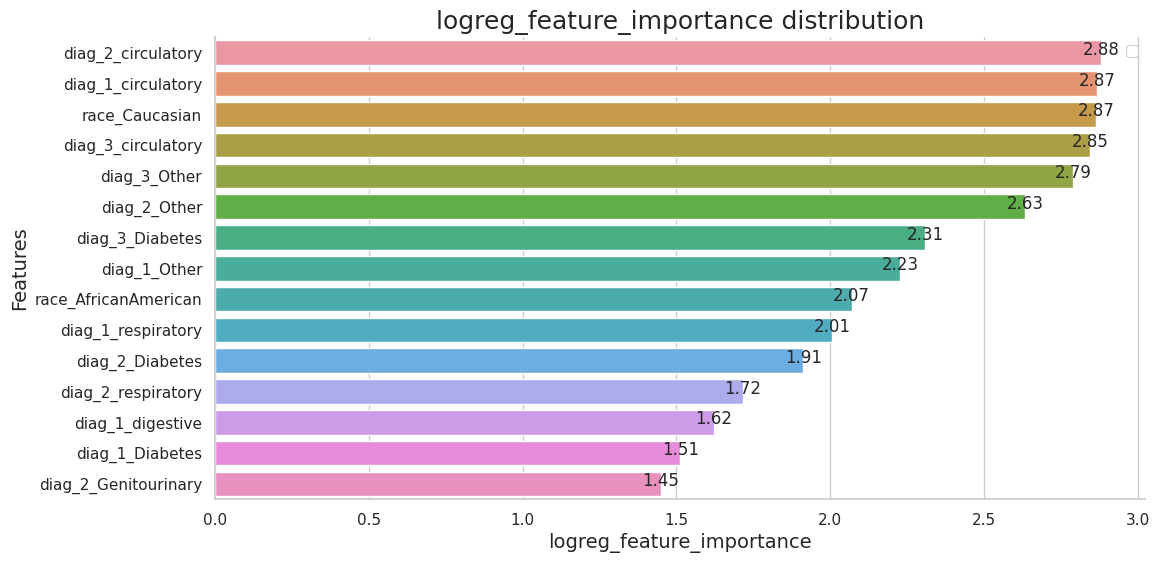

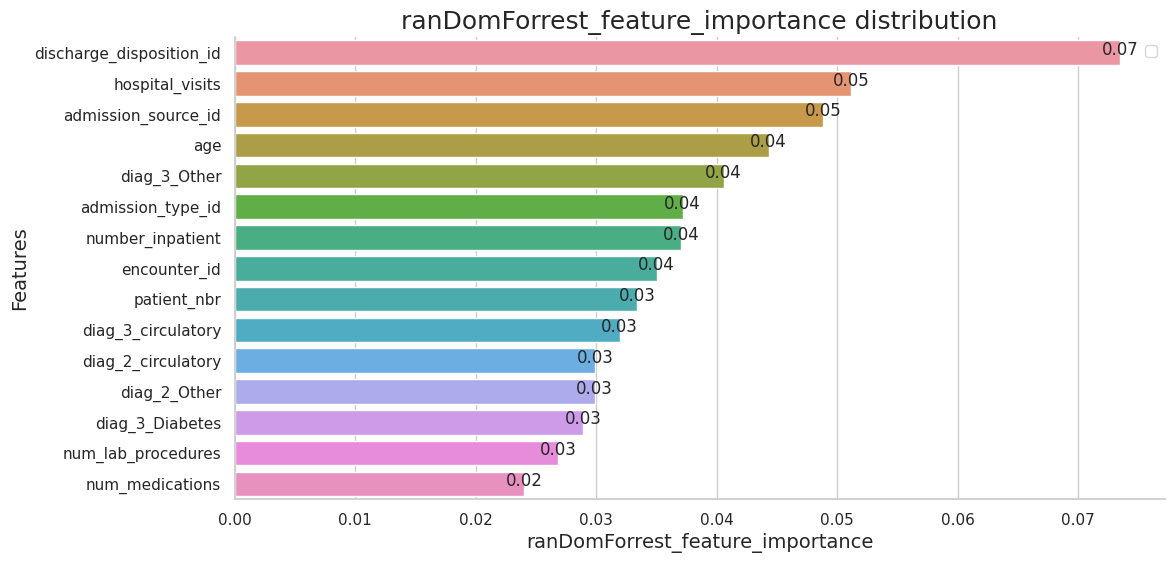

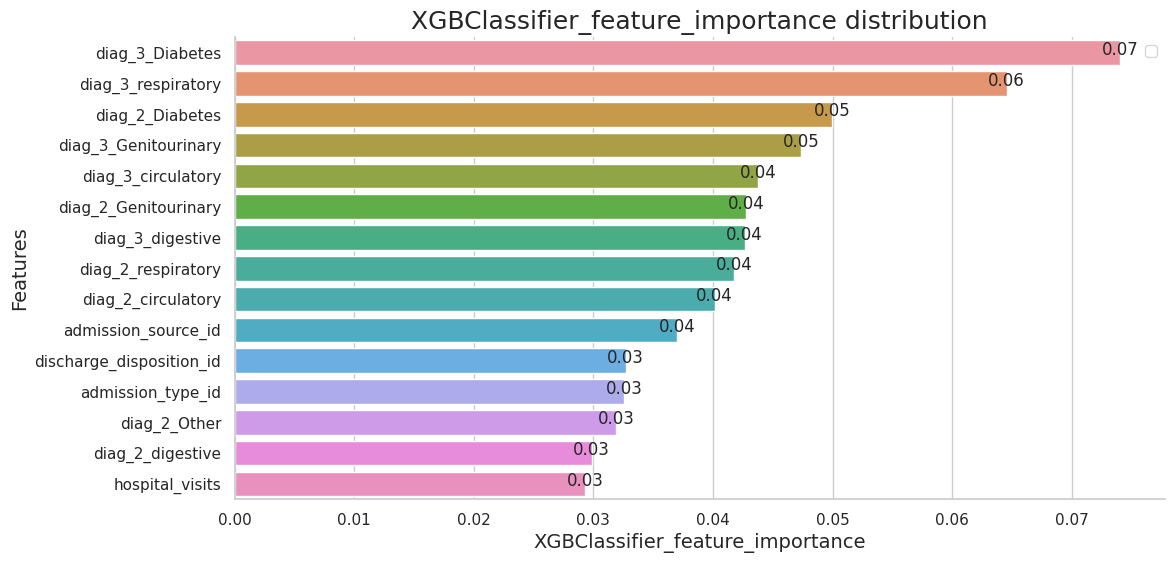

In [581]:


def feature_importance_visualization(coefficients,top,col):
    # Create a list of feature names
    feature_names = X_train.columns
    # Create a dictionary to store feature importance
    feature_importance = {}

    # Iterate over the coefficients and feature names
    for feature, coef in zip(feature_names, coefficients):
        feature_importance[feature] = abs(coef)

    importances = pd.DataFrame({'Features':feature_importance.keys(),col: feature_importance.values()}).sort_values(by=col,ascending = False)
    bar_plot(importances[0:top],col,'Features')
   

#Logistic regression
coefficients = ridge_logreg.coef_[0]
feature_importance_visualization(coefficients,15, 'logreg_feature_importance')

## Random forrest 
coefficients = rf_best.feature_importances_
feature_importance_visualization(coefficients,15,'ranDomForrest_feature_importance')

## Xgboost
coefficients = xb.feature_importances_
feature_importance_visualization(coefficients,15,'XGBClassifier_feature_importance')


In [582]:
raw_data

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,...,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,hospital_visits,num_increased_meds,num_decreased_meds
0,2278392,8222157,Caucasian,0,5.0,1.0,25.0,1.0,1,41,...,0,0,0,0,0,0,0,0,0.0,0.0
1,149190,55629189,Caucasian,0,15.0,1.0,1.0,7.0,3,59,...,0,0,0,0,1,1,0,0,1.0,0.0
2,64410,86047875,AfricanAmerican,0,25.0,1.0,1.0,7.0,2,11,...,0,0,0,0,0,1,0,3,0.0,0.0
3,500364,82442376,Caucasian,1,35.0,1.0,1.0,7.0,2,44,...,0,0,0,0,1,1,0,0,1.0,0.0
4,16680,42519267,Caucasian,1,45.0,1.0,1.0,7.0,1,51,...,0,0,0,0,1,1,0,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,443847548,100162476,AfricanAmerican,1,75.0,1.0,3.0,7.0,3,51,...,0,0,0,0,1,1,0,0,0.0,1.0
101762,443847782,74694222,AfricanAmerican,0,85.0,1.0,4.0,7.0,5,33,...,0,0,0,0,0,1,0,1,0.0,0.0
101763,443854148,41088789,Caucasian,1,75.0,1.0,1.0,7.0,1,53,...,0,0,0,0,1,1,0,1,0.0,1.0
101764,443857166,31693671,Caucasian,0,85.0,1.0,3.0,7.0,10,45,...,0,0,0,0,1,1,0,1,1.0,0.0


: 